In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

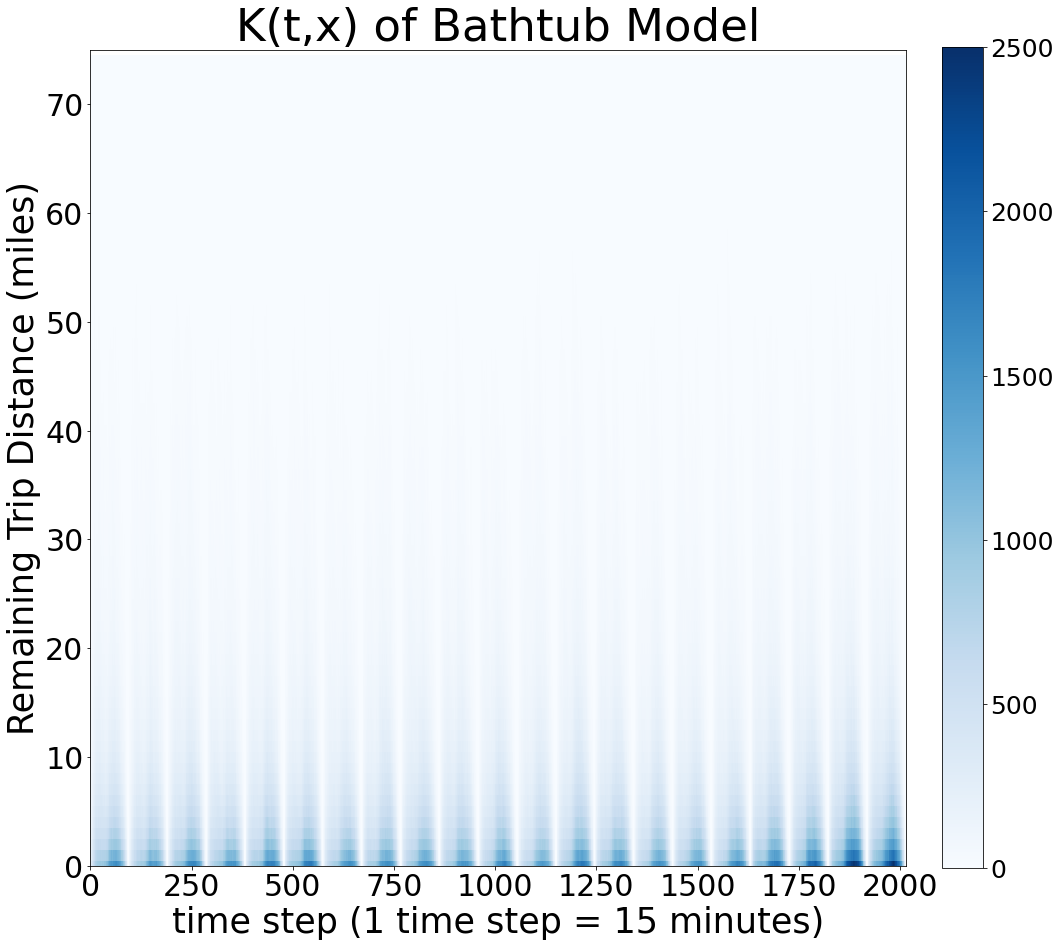

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.012667258830921214 0.024750837175403561 0.00058368048643886808 1.1989291235823067
0.011091470121969508 0.021707772971187075 0.00047516727275194118 1.1251877745182082
0.010060416187687285 0.019368906650718321 0.00075192572465625034 1.0649016262720477
0.0092860487683364742 0.017593776300014564 0.000978321236658386 1.0162960375767893
0.0072398019101125848 0.012979854553324462 0.0014997492669007087 0.8762920678527981
0.0059130243340123753 0.010198822746744107 0.0016272259212806429 0.7767605194673158
0.00577984191723416 0.010042443584155793 0.0015172402503125272 0.7696314920877
0.0057545741747252839 0.010062039026463503 0.0014471093229870644 0.7701492307269343
0.0056959475018103735 0.010128918844387 0.0012629761592337469 0.7723604963093015
0.0055999165662789915 0.010191095602437913 0.0010087375301200702 0.7744132813865078
0.0054093474909061258 0.010142930150250088 0.00067576483156216421 0.7724175869940589
0.0051531091369546329 0.0098457120068152909 0.00046050626709397515 0.761235411552245

0.0032159297416701855 0.0055228490287085406 0.00090901045463183015 0.5751159787638981
0.0032158265400012926 0.0055197332502763905 0.00091191982972619473 0.5749640841032567
0.0032154199679119587 0.0055114424734889434 0.00091939746233497377 0.574565939500348
0.0032151362061836218 0.0055107329462873687 0.00091953946607987449 0.5745459389580363
0.0032147667484206041 0.0055120587900848719 0.0009174747067563359 0.5746127592897695
0.0032144448946069965 0.0055145085376632095 0.00091438125155078294 0.5747341208981553
0.0032141195378001869 0.0055176337712108149 0.00091060530438955912 0.574882421462264
0.0032138781851294407 0.0055146393360111928 0.00091311703424768853 0.5747171565948189
0.0032137506543012907 0.0055117241290449951 0.00091577717955758581 0.5745691171694998
0.0032134760865736938 0.0055090943663157659 0.0009178578068316217 0.574435903076615
0.0032130154509524603 0.0055071491068815794 0.00091888179502334119 0.5743338852506636
0.0032124787112487387 0.0055074523245652448 0.0009175050979

0.0031804894774541802 0.0054547609074774069 0.00090621804743095378 0.571017357910216
0.0031799470133895258 0.0054422979338913484 0.00091759609288770308 0.570342722431937
0.0031795948378697163 0.0054538925856825737 0.00090529709005685911 0.5709047850847594
0.0031794732394549176 0.00544024042301911 0.00091870605589072535 0.5701739883197308
0.0031794039609038902 0.0054397749762182769 0.0009190329455895038 0.5701820559522254
0.0031793415120810833 0.0054467513537016059 0.00091193167046056071 0.5705278230313394
0.0031792929050908046 0.0054510866875861234 0.00090749912259548561 0.570741683979282
0.0031791929249053953 0.0054486992289773748 0.000909686620833416 0.570623862356129
0.0031790999927877404 0.0054500599567767344 0.00090814002879874647 0.5706905495855688
0.0031790331159423416 0.0054529867681904071 0.00090507946369427594 0.5708332284609023
0.0031789276895939213 0.0054552879160592862 0.00090256746312855607 0.570942118408422
0.0031784399135237149 0.0054542669229791733 0.000902612904068256

0.0031702917686097639 0.0054354113819724192 0.00090517215524710867 0.5697954913034801
0.0031702645358505947 0.0054331784400803744 0.00090735063162081546 0.5696679872249953
0.0031702462039701574 0.0054299147830140547 0.00091057762492626013 0.5694962807241263
0.0031702254444612712 0.0054331437728121976 0.00090730711611034442 0.5696593750556608
0.0031702188188506629 0.0054336339322119754 0.00090680370548935072 0.5696829386395564
0.0031701954800961588 0.0054336345939631691 0.000906756366229148 0.5696774207306131
0.0031701721658648771 0.0054340541836007047 0.00090629014812904942 0.5696937175668767
0.0031701153221939324 0.0054344784395288512 0.00090575220485901344 0.5697052952597899
0.0031700838524868344 0.0054304885825427014 0.00090967912243096721 0.5694945509310806
0.0031700536531968377 0.0054298921441145384 0.0009102151622791372 0.5694694333425443
0.0031700221433899746 0.005431710724220956 0.00090833356255899287 0.5695584241471657
0.0031699837642478728 0.0054371474418556647 0.000902820086

0.003166393819744367 0.0054212486820023722 0.000911538957486362 0.5690857929773141
0.0031662932142700372 0.0054246334540675673 0.00090795297447250753 0.5692355477040721
0.0031662498723705307 0.0054266527450306272 0.00090584699971043409 0.5693196644160545
0.0031662116405637496 0.0054263032075605247 0.00090612007356697462 0.5693142747507417
0.0031661712835359852 0.00542423010867198 0.000908112458399991 0.5692111578063646
0.0031661643872819361 0.0054248824331772682 0.000907446341386604 0.56923861977864
0.0031661535757835976 0.0054242052038292249 0.0009081019477379707 0.5692083343763589
0.0031661385824804981 0.005423580537424008 0.000908696627536988 0.5691800167620671
0.0031661080315835738 0.005423429500711399 0.00090878656245574829 0.56918021501193
0.0031660691249660216 0.0054231186675169126 0.00090901958241513061 0.5691627556054165
0.0031660221095412451 0.0054241537829061541 0.000907890436176336 0.5692215826990892
0.00316598148821037 0.00542526896400419 0.00090669401241654987 0.569273453

0.0031422309950398662 0.0053911666643261316 0.000893295325753601 0.5673007561498604
0.0031371322412917244 0.0053995414249323487 0.00087472305765110014 0.56774448140635
0.003136558652346431 0.0053839734874249487 0.00088914381726791307 0.5669533797402565
0.0031353893325077008 0.0053828418773229194 0.00088793678769248175 0.5668325279332951
0.0031333568328679806 0.0053853238737250723 0.00088138979201088884 0.56693031085095
0.0031325766854662907 0.0053620483799187765 0.00090310499101380515 0.56570666999172
0.0031314275788892282 0.0053750131696157629 0.0008878419881626936 0.5664240784321513
0.0031305913573826762 0.0053780964493670164 0.00088308626539833639 0.5665438359462762
0.0031282301870349904 0.0053503269931066437 0.0009061333809633372 0.5650944806722403
0.0031280009175050708 0.0053816373324485989 0.00087436450256154238 0.566687378162454
0.0031268286512828205 0.0053869742038062818 0.000866683098759359 0.5670042101230237
0.0031259158833115814 0.0053575162255320259 0.00089431554109113654 0

0.0030844617675387523 0.00530221154330423 0.00086671199177327477 0.5622512049386532
0.0030826495257012718 0.0052886577424167908 0.00087664130898575251 0.5615733381889256
0.0030808576632768347 0.0052839425867935693 0.0008777727397601 0.5613120138056603
0.0030797480731111493 0.0052702483636183524 0.0008892477826039464 0.5606554697126014
0.003078807766374318 0.005261990090655754 0.00089562544209288231 0.560249993244231
0.003077949609645607 0.0052676558990884595 0.00088824332020275443 0.5605118336769493
0.00307718581062372 0.0052526343403838235 0.00090173728086361666 0.5597359591161735
0.0030763905169040144 0.0052766204671925807 0.00087616056661544788 0.5610070103034431
0.0030750507973588449 0.005274387648590239 0.00087571394612745066 0.5608784820329863
0.0030733839580421359 0.00527388593046988 0.00087288198561439169 0.5608890699172423
0.0030715278756314234 0.0052832211204087024 0.00085983463085414417 0.5613956782532186
0.0030708254473836459 0.0052643291204667762 0.00087732177430051587 0.5

0.0030251989980719721 0.0051646955541285742 0.00088570244201537009 0.5550742654207402
0.0030250155879782861 0.0051611278968171316 0.00088890327913944032 0.5548979505486388
0.003024852065072174 0.0051616868925217366 0.000888017237622611 0.5549108719870653
0.0030247354378611941 0.0051588273794549852 0.00089064349626740292 0.5547471709309706
0.0030246620272971433 0.0051591040390752052 0.00089022001551908162 0.5547517858508149
0.0030245994507289067 0.0051586584656182159 0.00089054043583959748 0.5547282559033243
0.00302453924598466 0.0051575300136101013 0.00089154847835921838 0.5546709881925065
0.0030245015719816346 0.0051552592267214347 0.00089374391724183415 0.5545524140045259
0.0030244601590935991 0.0051531600446564326 0.0008957602735307651 0.5544487051839588
0.0030243947527153394 0.0051496474760853294 0.000899142029345349 0.5542584856488273
0.0030242690954263725 0.0051491378135984645 0.00089940037725428084 0.5542443836924816
0.0030241057272343444 0.0051470411980854367 0.0009011702563832

0.0030119944499651958 0.0051206824356995169 0.00090330646423087465 0.5526379728577152
0.0030118399188009326 0.0051253973351068922 0.00089828250249497307 0.552884903623428
0.0030116876199008445 0.0051281934362112118 0.00089518180359047757 0.5530361611504946
0.0030115451695916281 0.0051297943728913324 0.00089329596629192409 0.5531342058830169
0.003011319071383274 0.0051286996367008236 0.00089393850606572464 0.553094787733241
0.0030110767664775252 0.0051202369790991128 0.00090191655385593724 0.5526594331096447
0.0030110241289002522 0.0051189311969270894 0.0009031170608734153 0.5526043547258579
0.003010985435058807 0.0051169341212939749 0.00090503674882363939 0.5524787587189067
0.0030109773752378015 0.005117780813393564 0.00090417393708203933 0.5525261387027273
0.0030109392692225703 0.005118592435886124 0.00090328610255901651 0.5525668594207029
0.0030109129238153646 0.0051180398162851658 0.00090378603134556336 0.5525369070773436
0.0030108900390370171 0.0051204280323736114 0.000901352045700

0.0030046142780119989 0.0051058257876880854 0.00090340276833591245 0.5518273226858424
0.0030045095250958213 0.005106541420456686 0.00090247762973495618 0.5518700380532828
0.0030043548029642358 0.0051041871524854943 0.00090452245344297755 0.5517422042263761
0.003004245237605287 0.005105511329834304 0.00090297914537627 0.5518127787736317
0.0030040881038093607 0.0051101708078970043 0.00089800539972171656 0.5520482415264166
0.0030040124274697821 0.0051066760013945877 0.0009013488535449764 0.5518480823191398
0.0030039212548572366 0.0051082337530643585 0.00089960875665011462 0.5519333768696143
0.0030038109012045355 0.005110450844472321 0.00089717095793674987 0.5520478403143667
0.0030037481648894685 0.0051064777388058471 0.00090101859097308954 0.5518502757113193
0.0030036290155466181 0.0051091593837356286 0.00089809864735760768 0.552004109012776
0.0030035512505981921 0.0051067868373700443 0.00090031566382634009 0.5518625766352993
0.0030034807539369495 0.0051105649262306969 0.00089639658164320

0.0029971756002698437 0.0050888890044405504 0.00090546219609913671 0.5508779468895353
0.0029971306064163284 0.0050904499930009405 0.00090381121983171666 0.5509750372245084
0.0029970584479070404 0.0050880827511222233 0.00090603414469185735 0.5508599593803974
0.0029970068351747427 0.0050825043801213136 0.00091150929022817159 0.5505632014889897
0.0029968734079691035 0.00508890959956433 0.00090483721637387739 0.5509074533815203
0.0029966748742262196 0.0050902898985053825 0.000903059849947057 0.5509739818297613
0.002996457803128307 0.0050974277822824722 0.00089548782397414156 0.551329091452303
0.0029963252464118122 0.0050981238692714148 0.00089452662355220974 0.5513661757711598
0.0029959263857862453 0.00508799050124134 0.00090386227033115109 0.5508164837048136
0.00299568579240434 0.0050926061678678476 0.000898765416940833 0.5510701503015067
0.0029954466649629993 0.0050919174535376966 0.00089897587638830187 0.5510469177345709
0.0029951453187051008 0.0050950450881107768 0.00089524554929942433

0.0029863145922127492 0.005053340014837435 0.00091928916958806321 0.549069440200433
0.0029862175892548452 0.005061102713646186 0.00091133246486350451 0.5495068431917861
0.0029861360502623693 0.0050643861449803174 0.00090788595554442081 0.5496622321404125
0.0029860806184020647 0.0050531611065232429 0.00091900013028088645 0.5490888202116955
0.0029857941018696767 0.0050564247908752632 0.00091516341286409055 0.5492528361357912
0.0029856834644980358 0.0050572907334889873 0.00091407619550708382 0.5493100013858668
0.0029855490443754995 0.0050537123741374226 0.00091738571461357594 0.5491293663225161
0.0029854180552835652 0.0050542284496728259 0.00091660766089430451 0.5491587090927754
0.0029853742584356213 0.0050507469741951881 0.00092000154267605453 0.5489859938971936
0.0029853421392272571 0.0050531532886575747 0.00091753098979693957 0.5491152269212819
0.0029853114487216636 0.0050531209508490596 0.000917501946594268 0.5491058233786175
0.0029852607005236629 0.0050539765767553674 0.0009165448242

0.0029782677353058984 0.0050478951338066395 0.00090864033680515684 0.5486465233502447
0.0029782129077350222 0.0050503514094012245 0.00090607440606881961 0.5487801323794624
0.0029781395654458758 0.0050513636728301671 0.00090491545806158438 0.5488303362878152
0.0029780031079175533 0.0050501253605885286 0.00090588085524657817 0.5487689292521813
0.002977895551527623 0.0050490456388075713 0.00090674546424767484 0.5487280343977194
0.0029777707528905717 0.0050494551903378 0.0009060863154433436 0.5487598418166053
0.0029775646670768948 0.00504629905871159 0.00090883027544219977 0.5486129897603904
0.0029773824978721591 0.00505107238756272 0.000903692608181598 0.5488853556078348
0.0029772882094368743 0.0050483937434809773 0.0009061826753927715 0.5487313996102875
0.002977206494082168 0.0050422728875486227 0.000912140100615713 0.5484065825231477
0.0029770784445092621 0.0050500405998254319 0.00090411628919309249 0.5487950602381555
0.00297702084503935 0.0050536320632054267 0.00090040962687327314 0.54

0.002969921660521231 0.0050376638796879982 0.00090217944135446352 0.5482145334690455
0.0029698961656330573 0.0050380903436578446 0.00090170198760827021 0.5482442879991327
0.0029698601257294888 0.0050394303069702046 0.00090028994448877351 0.5483101136308517
0.0029698040931470139 0.0050384080525989585 0.00090120013369506913 0.5482513229420238
0.0029697067396005426 0.0050372467648127084 0.00090216671438837651 0.5481961286082044
0.0029696635796411797 0.0050346735045054 0.00090465365477695894 0.548058664329947
0.0029695987619218641 0.0050345643919440979 0.00090463313189963017 0.548049808032807
0.0029695269045574 0.0050385401823330473 0.00090051362678175251 0.5482574073569092
0.0029694045528703664 0.0050362010383960864 0.00090260806734464663 0.5481303387963231
0.00296929379854457 0.0050344090073027653 0.00090417858978637463 0.548037843084904
0.002969206433886251 0.0050348337503383052 0.00090357911743419708 0.5480537334329789
0.0029691513840269784 0.0050305719980692559 0.00090773076998470125 

0.0029640048408702165 0.005021270328612464 0.00090673935312796843 0.5473143812424871
0.0029639743948357065 0.0050249812717699325 0.00090296751790148078 0.5475172331185804
0.0029639459868157684 0.00502317213700551 0.00090471983662602682 0.547416338488713
0.0029639111629640854 0.0050211385151928342 0.00090668381073533708 0.547302035691934
0.0029638668368987629 0.00502137008087176 0.0009063635929257663 0.5473083178423347
0.002963816019713092 0.0050223620795911373 0.00090526995983504673 0.5473627633296889
0.0029637801914845566 0.0050196145801357488 0.00090794580283336474 0.5472154432845717
0.0029637386128488008 0.0050274221378831694 0.00090005508781443267 0.5476356255118005
0.0029636890285188408 0.0050235146411452946 0.000903863415892387 0.5474333134266497
0.0029636563984429035 0.0050211283154803586 0.00090618448140544858 0.5473032423815708
0.0029636318373541179 0.0050240337577584148 0.00090322991694982084 0.547459001841409
0.0029636119694384632 0.0050218044349734873 0.00090541950390343956

0.0029588386326916244 0.005006124826160867 0.00091155243922238182 0.546560586298492
0.0029588261845676922 0.0050063845233992857 0.00091126784573609867 0.5465773553415473
0.0029588060939136412 0.005006944454100954 0.000910667733726328 0.5466138045233095
0.0029588008752258949 0.0050069628427485075 0.00091063890770328208 0.5466116211494767
0.002958747591259853 0.0050083301573317961 0.00090916502518791022 0.5466892608045227
0.00295872540426946 0.0050083622838672411 0.000909088524671679 0.5466892085446131
0.0029586952925972211 0.0050084661480217186 0.00090892443717272378 0.5466928981693193
0.0029586722922767556 0.0050086740517946626 0.00090867053275884863 0.5466981286761424
0.0029586545983707737 0.0050076551035185988 0.00090965409322294843 0.5466472398154318
0.0029586418652828889 0.0050086593075325354 0.00090862442303324225 0.5466972219157674
0.0029586362948204625 0.0050088155145018619 0.000908457075139063 0.5467072865266678
0.0029586276095375508 0.0050092996540003435 0.00090795556507475815

0.0029559730253832213 0.0049986717760087352 0.00091327427475770709 0.5461007804421512
0.002955871748515766 0.0049979202645790716 0.0009138232324524603 0.5460647149211015
0.0029557258848828035 0.0049987759988179446 0.00091267577094766221 0.5461276811000927
0.0029555829392971951 0.0050024741758670638 0.00090869170272732619 0.5463260506051911
0.0029554571738894197 0.0050062110435716168 0.00090470330420722243 0.5465339504741722
0.0029553983689776559 0.0050134615545754449 0.00089733518337986671 0.5469370504589267
0.0029553268614362395 0.0050068811612165223 0.00090377256165595694 0.5465762029177885
0.0029553056903623767 0.0050043300462880554 0.00090628133443669838 0.5464377101482092
0.0029552512709361419 0.0050035071229895126 0.00090699541888277153 0.5463873430045552
0.0029552097242628852 0.0050050062399013568 0.00090541320862441363 0.5464676338311991
0.0029551708742301956 0.0050040809510613245 0.00090626079739906658 0.5464165119722225
0.0029551124770511791 0.0050040510030034766 0.0009061739

0.002951080437412849 0.0049898279503039576 0.00091233292452174092 0.5456294134011496
0.0029510656370066021 0.0049893378486714265 0.0009127934253417776 0.5456008530852285
0.0029510503346458421 0.0049887214426115583 0.00091337922668012614 0.5455684180581384
0.0029510337198378768 0.0049893714482546975 0.00091269599142105651 0.5456054058147751
0.002951018468053184 0.0049885862010041141 0.0009134507351022536 0.545560743551338
0.0029510016033185969 0.0049878408502758223 0.00091416235636137134 0.545523306103036
0.0029509803897175696 0.00498739116127351 0.00091456961816162882 0.5454998648922312
0.0029509566035003194 0.00498714010079948 0.00091477310620115921 0.5454845426933551
0.0029509254951256363 0.0049878137906081768 0.0009140371996430956 0.54551963966018
0.0029508904387534995 0.0049882524169618109 0.00091352846054518785 0.5455425118692626
0.0029508652511970267 0.0049917327443352961 0.00090999775805875743 0.5457291934222565
0.002950838975336721 0.0049908783303827982 0.00091079962029064416 0

0.0029481868256275023 0.0049848091044650241 0.00091156454678998093 0.5453116087951876
0.0029481709862224448 0.0049846178639059791 0.00091172410853891076 0.5453046573488591
0.0029481555118662118 0.00498328423454983 0.000913026789182593 0.5452402174192049
0.0029481392823615155 0.0049833155562045948 0.00091296300851843621 0.5452490025876517
0.0029481246085891998 0.0049831185507949972 0.00091313066638340251 0.545237915371307
0.002948112177639049 0.00498339587648867 0.00091282847878942854 0.5452534156360166
0.0029480984667891357 0.0049835778956279454 0.00091261903795032554 0.5452625768013062
0.0029480850367049685 0.0049839793402121748 0.000912190733197762 0.5452835744096278
0.0029480731072104344 0.0049836036494549825 0.00091254256496588648 0.5452625070074858
0.0029480618295505672 0.0049829992390964259 0.00091312442000470861 0.5452279434568673
0.0029480527762558821 0.0049833841946802307 0.00091272135783153319 0.5452445875284063
0.0029480380218199296 0.0049824678890947041 0.000913608154545155

0.0029460517322872056 0.0049858396802816571 0.00090626378429275393 0.545293560790538
0.0029460270813330548 0.0049862129964636159 0.00090584116620249394 0.5453058715113135
0.0029460095514533859 0.0049867083897129523 0.00090531071319381953 0.5453351978191467
0.0029459911029237327 0.0049845692553248328 0.00090741295052263263 0.5452203434353504
0.0029459779755515621 0.0049884276922044172 0.00090352825889870707 0.5454368384374306
0.0029459555028322165 0.00498685636466726 0.0009050546409971723 0.5453485753917306
0.0029459383819365674 0.0049862163844601234 0.00090566037941301151 0.5453080602696551
0.0029459175400355763 0.0049854884100109893 0.00090634667006016364 0.545263119528969
0.002945895681946413 0.0049866425122160858 0.00090514885167673992 0.5453221935684646
0.0029458837527193455 0.0049868163047665859 0.0009049512006721051 0.5453294695712899
0.0029458750306031903 0.0049858139963991554 0.00090593606480722543 0.5452786013014526
0.0029458688463069389 0.0049866135274260828 0.000905124165187

0.0029435284407291406 0.0049827191327567327 0.00090433774870154842 0.5450614677811069
0.0029435185506230962 0.0049830946804154362 0.00090394242083075623 0.545077768700954
0.0029435095407584475 0.0049839949060878023 0.00090302417542909258 0.5451244787734315
0.0029434964371042958 0.0049847451615655175 0.00090224771264307434 0.5451661910803092
0.0029434849914994972 0.0049856911346851645 0.00090127884831382992 0.5452194804403278
0.0029434738951946049 0.0049858051764667044 0.00090114261392250513 0.5452297358564032
0.0029434609310303537 0.00498604550079983 0.00090087636126087679 0.5452481539386567
0.0029434494403115514 0.0049841079124690523 0.00090279096815405063 0.5451453923826515
0.00294343694176306 0.0049837625945554041 0.00090311128897071623 0.5451280306429247
0.002943424071783959 0.00498334116761013 0.00090350697595778756 0.5451029298358293
0.0029434183680991065 0.0049820610218034456 0.00090477571439476722 0.5450339069287525
0.00294340992263352 0.0049827745534334091 0.000904045291833630

0.0029410766579566058 0.0049764816716722816 0.00090567164424092952 0.5448006125207165
0.0029410603005060663 0.0049776298677756551 0.00090449073323647727 0.544859310002029
0.0029410474000100238 0.0049763894265985563 0.00090570537342149146 0.5447884883375127
0.0029410321721974834 0.0049758822741047867 0.00090618207029017977 0.5447565232130146
0.0029410153672289464 0.0049754178167796233 0.00090661291767826985 0.5447295686463218
0.0029410008175308781 0.0049750282570920762 0.00090697337796968034 0.5447110935047209
0.0029409911976613478 0.0049749521998920833 0.00090703019543061242 0.5447101288730858
0.002940979075059975 0.0049753522817625384 0.00090660586835741126 0.5447296042381697
0.0029409752855202717 0.004976108583142411 0.00090584198789813223 0.5447780522827366
0.0029409651266983409 0.0049766911348243046 0.00090523911857237692 0.544806607850109
0.0029409603549728014 0.0049759220903348479 0.00090599861961075483 0.5447638461794868
0.0029409550564884921 0.0049759115674813106 0.000905998545

0.0029395790849545207 0.00497256051841473 0.00090659765149431106 0.544595579748342
0.0029395763929551816 0.0049720720206091248 0.00090708076530123839 0.544563467347438
0.0029395705844848219 0.0049725062179121031 0.00090663495105754058 0.5445848614226215
0.0029395632757280177 0.0049736488310140993 0.00090547772044193616 0.5446510446738505
0.00293955972389093 0.0049727344080409972 0.00090638503974086219 0.5446015486314799
0.0029395565280382727 0.0049723295858421527 0.00090678347023439264 0.5445771652470772
0.0029395521308476589 0.0049724185489461769 0.000906685712749141 0.5445782400773551
0.0029395508597894727 0.0049723182028281595 0.00090678351675078581 0.5445718277257602
0.0029395490688297545 0.0049726149770266039 0.00090648316063290523 0.5445868649902565
0.0029395427438183692 0.0049723848506112046 0.00090670063702553408 0.5445759772625535
0.0029395348740395765 0.0049732176142454794 0.0009058521338336737 0.5446174797714257
0.0029395214307362146 0.0049746344762829024 0.00090440838518952

0.0029384986143144555 0.0049702399200850641 0.00090675730854384694 0.5444323432419024
0.002938490408702624 0.0049716074017552535 0.00090537341564999425 0.5445058542819329
0.0029384818401790619 0.0049712933827507754 0.00090567029760734862 0.5444896318078916
0.0029384707500139215 0.0049705328731668762 0.000906408626860967 0.5444494897225339
0.0029384538845901149 0.0049701482921403672 0.00090675947703986273 0.5444297886665512
0.0029384341106847233 0.0049701818412322451 0.00090668638013720164 0.5444324897624746
0.0029384105464372841 0.0049705992974246691 0.00090622179544989955 0.5444620807760004
0.0029383892515515114 0.0049696212368940734 0.00090715726620894965 0.544407754330597
0.0029383614838906207 0.0049702449022397789 0.00090647806554146218 0.5444450869651815
0.00293833352882712 0.0049713963053112167 0.00090527075234302318 0.5445021377337198
0.0029383241528783211 0.004969005417650431 0.00090764288810621125 0.5443781947703031
0.0029382907463920268 0.004970839663046748 0.0009057418297373

0.0029371718798845026 0.0049689618638785477 0.00090538189589045766 0.544342530116133
0.0029371643481142539 0.0049687394123989854 0.00090558928382952232 0.5443299941659504
0.0029371550299948494 0.0049683935922430278 0.00090591646774667125 0.5443113266255174
0.0029371507792905179 0.0049695019715547553 0.0009047995870262802 0.5443671836878328
0.0029371476340276817 0.0049696787936850768 0.00090461647437028677 0.5443772490314792
0.002937136600960513 0.0049683411153422386 0.00090593208657878735 0.5443057185205444
0.0029371301221945809 0.0049690187496204347 0.000905241494768727 0.5443429391675116
0.0029371227951229088 0.0049675589636376813 0.00090668662660813677 0.5442619980556163
0.0029371165359670503 0.0049673345550112534 0.00090689851692284714 0.5442479520073592
0.002937111726252474 0.0049675462648633142 0.00090667718764163362 0.5442593472200222
0.0029371099097455318 0.0049676056860833437 0.00090661413340771947 0.5442626332707944
0.0029371075836845282 0.0049673027634876 0.00090691240388145

0.0029362754636636846 0.0049626444438006312 0.00090990648352673789 0.5440274592190618
0.002936274107610372 0.0049621468052368587 0.00091040140998388508 0.5440004528518889
0.0029362716079928608 0.0049628834179780293 0.00090965979800769264 0.5440396680575885
0.0029362704499615779 0.0049625940945566454 0.00090994680536651026 0.5440228247291445
0.0029362695257481087 0.0049625011056912364 0.00091003794580498071 0.5440177484826486
0.0029362677661564219 0.00496262306930176 0.00090991246301108414 0.544023150937976
0.00293626623353492 0.0049620357363253775 0.00091049673074446245 0.543991418652427
0.0029362645467371474 0.0049622457646966347 0.00091028332877766027 0.5440017033430109
0.0029362635460025389 0.0049622728628205418 0.00091025422918453636 0.5440022119503886
0.0029362624023363338 0.0049622998317708552 0.00091022497290181245 0.5440030382910602
0.0029362601644488118 0.00496186936580105 0.00091065096309657357 0.5439801866693722
0.002936257432407917 0.0049618675029471249 0.000910647361868708

0.0029356639146105655 0.00496164364826275 0.00090968418095838089 0.5439674604932823
0.0029356585883842721 0.0049617397405230532 0.000909577436245491 0.5439683849773004
0.0029356515128089304 0.0049618282030237252 0.00090947482259413567 0.5439720631400208
0.0029356439859062663 0.0049621997058570816 0.0009090882659554513 0.5439885671219904
0.002935638902903488 0.0049617560668312206 0.00090952173897575564 0.5439663652150953
0.0029356292482801975 0.0049623930712779946 0.00090886542528240068 0.544002545292082
0.0029356240212237285 0.004962554007651639 0.00090869403479581774 0.5440118367092154
0.00293561893904311 0.0049619556548073322 0.00090928222327888786 0.5439815885180949
0.0029356140008252088 0.0049618004488397229 0.000909427552810695 0.5439737751987938
0.0029356088211907223 0.0049619261027816089 0.00090929153959983574 0.5439827305521787
0.0029356048071304845 0.004960835439012423 0.00091037417524854553 0.54392588167951
0.0029356008232526497 0.0049615660271706222 0.00090963561933467729 0.

0.0029351346152481461 0.0049625973322910957 0.00090767189820519683 0.5440717343382067
0.0029351315789023467 0.0049626918611954188 0.00090757129660927482 0.5440771513723167
0.0029351259784650497 0.0049633783874319728 0.00090687356949812681 0.5441142900748291
0.0029351175676512243 0.0049633855615593865 0.00090684957374306222 0.5441166438579493
0.0029351021756970561 0.0049634673749708088 0.00090673697642330321 0.5441258370335059
0.0029350852293488767 0.0049635228710942459 0.00090664758760350742 0.5441314207273803
0.0029350625341026085 0.0049648848937643986 0.00090524017444081864 0.5442025314873495
0.0029350489150307742 0.0049639181563319807 0.000906179673729568 0.5441587792072039
0.0029350231168037157 0.0049658778379335616 0.00090416839567386965 0.5442570330779993
0.0029349993332762228 0.0049662863129799313 0.00090371235357251446 0.5442690184088181
0.0029349734732154339 0.0049640378545259311 0.00090590909190493667 0.5441515629094156
0.0029349549710271346 0.0049622188803414621 0.0009076910

0.0029341319283552915 0.0049621873586655745 0.000906076498045008 0.5440776347196704
0.0029341244843186457 0.00496230018601582 0.00090594878262147084 0.5440799178433944
0.00293411786571328 0.0049613481143250815 0.00090688761710147874 0.5440274833758374
0.0029341124427635485 0.0049616560330470608 0.00090656885248003639 0.5440462671404049
0.002934108528529435 0.0049611854124660239 0.00090703164459284631 0.5440224473025366
0.0029341038500161204 0.0049614973580096563 0.00090671034202258465 0.544040393135677
0.0029340948507766522 0.0049617400711692164 0.00090644963038408828 0.544055581063083
0.0029340879599804551 0.0049616111754034117 0.00090656474455749867 0.5440502974968938
0.0029340763447885483 0.0049610192537323534 0.000907133435844743 0.544018953626425
0.0029340564121690194 0.0049600304360199795 0.00090808238831805918 0.5439626805852442
0.0029340312800118225 0.0049613070121593784 0.00090675554786426662 0.5440267452980267
0.0029339944618702353 0.0049608296644920186 0.00090715925924845229

0.0029330539155225819 0.0049584963810083132 0.00090761145003685046 0.5439008151553492
0.0029330440147579272 0.0049583059899744406 0.00090778203954141354 0.5438911332581452
0.0029330319811602824 0.0049582405164008215 0.00090782344591974361 0.5438866085391171
0.00293302785680909 0.00495733171828413 0.00090872399533405048 0.5438388103855439
0.0029330217581257818 0.0049582549440415425 0.000907788572210021 0.5438876573620417
0.0029330144894505841 0.0049579774595743887 0.00090805151932677971 0.5438736706598813
0.0029330082860071138 0.0049579929388110684 0.00090802363320315906 0.5438751988443692
0.0029330006998606935 0.0049579415198876655 0.00090805987983372184 0.5438749019070961
0.0029329913078205939 0.0049587234176766935 0.000907259197964494 0.5439168031116732
0.0029329821378521422 0.0049588176342643857 0.00090714664143989843 0.5439206442930867
0.0029329740371531179 0.0049597771517971454 0.00090617092250908993 0.5439704791880707
0.0029329615050587895 0.004959472311558662 0.00090645069855891

0.0029318215043548624 0.004956299168950894 0.00090734383975883063 0.5437295528584021
0.0029318186619426367 0.0049559227001386551 0.00090771462374661816 0.5437101664459726
0.002931818045604911 0.0049560673364738121 0.00090756875473600957 0.5437188663342547
0.0029318142182008242 0.0049560495877329592 0.00090757884866868917 0.5437178516350942
0.0029318112386144792 0.00495616332971606 0.00090745914751289838 0.5437242179212313
0.0029318077183853319 0.00495612698227242 0.00090748845449824429 0.5437231861337467
0.002931803025801108 0.004956012871194365 0.00090759318040785114 0.5437179020781576
0.0029317965469726807 0.00495538054939922 0.00090821254454614118 0.5436845444437758
0.0029317911014992573 0.0049546488464513655 0.000908933356547149 0.5436417844290768
0.0029317873458262018 0.004954264215918003 0.00090931047573440042 0.5436203956530301
0.0029317833622322974 0.0049540011748521748 0.00090956554961241969 0.5436014904151482
0.0029317777498698988 0.0049541894717715319 0.00090936602796826539 

0.0029310281966560361 0.0049545595569397 0.000907496836372372 0.543639891369104
0.0029310167174172118 0.004954117469807541 0.00090791596502688265 0.5436211281653724
0.0029310074548687766 0.0049530196399795107 0.00090899526975804284 0.5435643797138419
0.0029309947450066615 0.0049541774934387522 0.00090781199657457038 0.5436269626859722
0.002930985584268147 0.0049539633754503206 0.00090800779308597326 0.5436151143165806
0.0029309797785245684 0.0049541292471817332 0.00090783030986740332 0.5436198758112688
0.0029309751773568763 0.0049533274080299878 0.00090862294668376457 0.5435771301765494
0.0029309686940329829 0.00495208040226835 0.00090985698579761586 0.5435110110068929
0.0029309622508372612 0.0049515049769297244 0.00091041952474479805 0.5434819635391782
0.0029309516013672483 0.0049501177448005688 0.000911785457933928 0.5434090347621282
0.0029309402529862079 0.0049502903936863608 0.000911590112286055 0.5434197645237893
0.0029309280023325796 0.0049509232159960209 0.00091093278866913882 0

0.0029304895151018679 0.00495246076890262 0.00090851826130111549 0.543523398228029
0.002930489126980163 0.0049521920368594133 0.00090878621710091263 0.5435053461211465
0.002930486914093556 0.0049522851963717147 0.000908688631815397 0.54351261390753
0.0029304852139217636 0.0049522960827558917 0.00090867434508763538 0.5435134472057361
0.0029304828746163133 0.0049522466620368468 0.00090871908719577978 0.5435096968166673
0.0029304794347173924 0.00495228358175598 0.00090867528767880489 0.5435103325804036
0.0029304765370050216 0.004952066351241278 0.00090888672276876479 0.5434956606178373
0.0029304732614132676 0.0049517228723368846 0.00090922365048965077 0.5434789542633457
0.002930470568970076 0.0049516989407596855 0.00090924219718046661 0.5434780757163382
0.0029304681141726326 0.0049513934655880908 0.00090954276275717432 0.543459956170765
0.0029304652380567134 0.0049515058157600846 0.00090942466035334182 0.5434675315832724
0.0029304621538574767 0.0049519269290027226 0.00090899737871223045 0

0.0029300852399551129 0.0049529323755487381 0.00090723810436148765 0.543548156462143
0.0029300826785870135 0.0049529882783576938 0.00090717707881633324 0.5435505469364231
0.0029300803306407624 0.0049533820637010654 0.00090677859758045952 0.5435706830074277
0.0029300779403798457 0.0049537933916441431 0.000906362489115548 0.5435929953787537
0.0029300769035982741 0.0049537134200881849 0.00090644038710836327 0.5435885293562922
0.0029300746506843076 0.0049535986866055624 0.00090655061476305307 0.5435829093191752
0.0029300718508218481 0.0049533506762632906 0.00090679302538040592 0.5435690024556589
0.002930070057511505 0.0049535341908641135 0.00090660592415889676 0.5435764998493192
0.0029300679142605195 0.0049530734181302974 0.00090706241039074128 0.5435514739087822
0.0029300650655360661 0.0049527917809648065 0.00090733835010732545 0.5435354832955496
0.0029300626049189784 0.0049526484760478691 0.0009074767337900881 0.5435286397063293
0.0029300602357417876 0.0049527096708276335 0.0009074108006

0.0029296666057521824 0.0049514672161415163 0.00090786599536284856 0.5434702999120593
0.0029296654818923309 0.0049516254671421117 0.00090770549664254976 0.5434782011849127
0.0029296644798248697 0.004951684614088429 0.00090764434556131078 0.5434802482831491
0.0029296637542749818 0.004951677996682652 0.00090764951186731151 0.5434809156061579
0.0029296631825889647 0.0049515399059710929 0.00090778645920683645 0.5434745196292653
0.0029296626742664113 0.0049514679977385821 0.00090785735079424064 0.5434717457811694
0.0029296623837065053 0.0049514961260441409 0.00090782864136886943 0.5434740968879753
0.0029296620839121563 0.00495143801846049 0.00090788614936382285 0.5434711638775793
0.0029296617161467288 0.0049515735923328025 0.0009077498399606553 0.543478341538428
0.0029296611968729564 0.0049514326175477286 0.000907889776198184 0.5434709112608591
0.0029296607071372326 0.0049515511064351578 0.00090777030783930712 0.5434773955598922
0.0029296600428442049 0.0049516208204234786 0.0009076992652649

0.0029292180535328816 0.0049504039089974805 0.000908032198068283 0.5434070022524685
0.0029292154482391548 0.0049500494730242532 0.00090838142345405675 0.543388309129524
0.0029292140839392369 0.004950526796212 0.000907901371666474 0.5434145034986502
0.0029292116798068151 0.0049512991840903282 0.00090712417552330166 0.5434549802145195
0.0029292084917487311 0.0049511356192028944 0.00090728136429456816 0.5434453340856543
0.0029292062865935711 0.004951029249907756 0.000907383323279386 0.5434387352081763
0.0029292045003023294 0.004951355425113972 0.00090705357549068712 0.5434557996851419
0.0029292027462496763 0.0049516398324200676 0.00090676566007928477 0.543470350888579
0.00292919981051248 0.0049517394603474478 0.000906660160677512 0.5434752446429401
0.0029291955255884884 0.00495223283733841 0.000906158213838566 0.5435024768508186
0.0029291906096917059 0.0049518407469016966 0.00090654047248171516 0.5434782527842471
0.002929186134054807 0.0049517663984933735 0.00090660586961624045 0.54347578

0.0029289006668594543 0.0049496435651401249 0.00090815776857878377 0.5433784219581644
0.0029288949705809169 0.0049496473368970968 0.00090814260426473668 0.5433799824110186
0.0029288899807751521 0.0049505953305822121 0.00090718463096809245 0.5434294019110588
0.0029288883615475173 0.0049507645863151612 0.00090701213677987368 0.5434372380127808
0.0029288842077075353 0.004951343267668694 0.00090642514774637675 0.5434682709185927
0.002928881741670089 0.0049511625750736418 0.0009066009082665359 0.5434595665865443
0.0029288770224317577 0.0049511265367761115 0.00090662750808740387 0.5434578314017654
0.0029288704276060626 0.0049510900223520447 0.00090665083286008055 0.5434538145629612
0.0029288656378878442 0.0049515239442026989 0.00090620733157299 0.5434757567170853
0.0029288597655193491 0.0049516200652561949 0.00090609946578250344 0.5434788356339719
0.0029288516399858006 0.0049515667924236876 0.00090613648754791349 0.5434741924339883
0.0029288454407970909 0.0049515655641651363 0.00090612531742

0.0029284886336801473 0.00495251229610025 0.00090446497126004451 0.543505924949349
0.0029284836562114315 0.00495190552584823 0.00090506178657463287 0.5434714201008527
0.0029284788133838256 0.0049524981347256417 0.00090445949204200971 0.5435045849900028
0.0029284731153357349 0.0049528901441587593 0.00090405608651271049 0.5435265015491914
0.0029284631198678735 0.0049532493045212423 0.00090367693521450475 0.5435450799107517
0.0029284508106852724 0.0049535731499843185 0.00090332847138622607 0.5435673115199104
0.0029284373291604575 0.0049536579970210354 0.00090321666129987942 0.5435669810069454
0.0029284244054502647 0.0049544769499715721 0.00090237186092895737 0.5436007840551043
0.0029284090261344851 0.0049535501008889813 0.00090326795137998838 0.543550534902334
0.0029284003472900143 0.0049537405920441428 0.00090306010253588551 0.5435577959680213
0.0029283766779140985 0.00495314326529882 0.00090361009052937653 0.5435302378279269
0.0029283618076955311 0.00495235313538011 0.000904370480010951

0.0029275598541036682 0.0049472066678391763 0.0009079130403681603 0.5432325202720927
0.0029275579598464375 0.0049478051832397051 0.00090731073645317008 0.5432643767024031
0.002927556255483335 0.0049477259217406873 0.0009073865892259825 0.5432608426586768
0.0029275532435755953 0.0049475633732198876 0.00090754311393130311 0.5432531616227138
0.0029275500174658214 0.0049475837390373142 0.0009075162958943286 0.5432560511533524
0.0029275446791020539 0.004947653176303992 0.00090743618190011548 0.5432611656419591
0.0029275375492561553 0.0049469718062339386 0.00090810329227837192 0.5432213350276831
0.0029275269431067535 0.0049479746264804916 0.000907079259733015 0.5432728106736182
0.0029275174970786479 0.004947343488408573 0.00090769150574872314 0.5432401698963776
0.00292750696230178 0.00494719017888286 0.00090782374572069959 0.5432310051377475
0.0029274930909471862 0.004946740935898382 0.00090824524599598987 0.5432069072342136
0.0029274870555206648 0.0049481087873191618 0.00090686532372216742 

0.002927138790726608 0.004944641869824698 0.00090963571162851783 0.5431008564297056
0.0029271139724928895 0.0049435034372252466 0.00091072450776053264 0.5430303810812932
0.002927109947030361 0.0049443743299149873 0.00090984556414573474 0.5430749063662947
0.0029270893047739187 0.0049457955822028374 0.00090838302734499987 0.5431511574723416
0.0029270768714861365 0.0049444666316596081 0.00090968711131266488 0.5430783235135996
0.0029270605468049919 0.0049446433087728253 0.0009094777848371587 0.5430885745454925
0.0029270367662600962 0.0049464936372814079 0.000907579895238785 0.5431885045335391
0.00292702019046093 0.0049467574193116934 0.00090728296161016642 0.5432044383542528
0.002927003827149539 0.0049457533997393811 0.00090825425455969672 0.5431470394791201
0.0029269816345895319 0.004946341431389451 0.00090762183778961281 0.543175812993815
0.0029269647922035235 0.0049452064619963185 0.00090872312241072821 0.5431140289461172
0.0029269507448774221 0.004947856494582157 0.00090604499517268693

0.0029262911699611581 0.0049439884095986725 0.00090859393032364383 0.5430584943863515
0.0029262872561367456 0.0049449116506671883 0.000907662861606303 0.5431091519301665
0.0029262846353666772 0.00494492989598503 0.00090763937474832408 0.5431104034510836
0.0029262803104508927 0.0049453065331226372 0.00090725408777914834 0.5431288099633881
0.0029262777179943637 0.0049450347482138972 0.00090752068777483 0.5431105184104865
0.0029262752793197339 0.0049450376729063879 0.00090751288573307973 0.5431090275033169
0.002926272572342637 0.0049450084325781832 0.00090753671210709065 0.5431072543155228
0.0029262692145342216 0.004944836019650109 0.00090770240941833444 0.5430991876228786
0.0029262646716491686 0.0049456633118580944 0.000906866031440243 0.543142562794804
0.0029262600101853725 0.0049455712536989483 0.00090694876667179688 0.5431378045837102
0.002926253808411463 0.004945456515738563 0.00090705110108436318 0.5431319319916269
0.0029262485982999168 0.0049450371335717147 0.00090746006302811876 0

0.0029257980290038183 0.00494596992399236 0.00090562613401527694 0.5431663408518697
0.0029257947419131752 0.0049456055334716927 0.00090598395035465745 0.5431469235844932
0.0029257901677332415 0.0049455669015465555 0.00090601343391992744 0.5431399303412007
0.0029257847724904157 0.0049454558035066567 0.00090611374147417433 0.5431324751780555
0.0029257822761734097 0.0049458082045039462 0.00090575634784287361 0.5431485086431699
0.0029257791369836461 0.0049456152736667989 0.00090594300030049312 0.5431370772397266
0.0029257761037302724 0.0049456711460427608 0.000905881061417784 0.5431417402343712
0.0029257731698155223 0.0049459866656459718 0.0009055596739850724 0.5431595078402752
0.0029257699993185367 0.0049462741824893835 0.00090526581614768984 0.5431769515821331
0.0029257657223408359 0.004946155525396843 0.00090537591928482885 0.5431723578311378
0.0029257583053745968 0.0049459221428963867 0.000905594467852807 0.5431631637417527
0.0029257512910729885 0.0049454067532616244 0.0009060958288843

0.0029254808938118781 0.004944612389500001 0.00090634939812375519 0.5430927141733863
0.0029254790811659237 0.0049445213986691224 0.000906436763662725 0.5430888047966809
0.0029254771255034636 0.004944904380666762 0.00090604987034016531 0.5431093946650031
0.0029254741314365157 0.0049448911842115617 0.00090605707866146963 0.5431094243949469
0.0029254718078098032 0.0049449130574626861 0.00090603055815692026 0.5431110244547851
0.0029254679815848088 0.00494409870703207 0.00090683725613754766 0.5430644690184432
0.0029254631238861033 0.0049445805638383975 0.00090634568393380881 0.5430881718674008
0.0029254583477048451 0.0049448123071358253 0.0009061043882738648 0.5431016574094466
0.0029254540343452602 0.0049447241889739747 0.00090618387971654545 0.5430984665632403
0.0029254507208141441 0.0049448152058009206 0.00090608623582736768 0.5431020683701364
0.0029254455758122512 0.0049444934862830983 0.00090639766534140413 0.543081935687375
0.0029254399107697584 0.0049444661932857821 0.0009064136282537

0.0029250472005161372 0.0049422626513502708 0.00090783174968200344 0.5429556758670638
0.0029250448261586544 0.00494253268524569 0.00090755696707161854 0.5429692752377426
0.0029250431692785335 0.00494219230386359 0.00090789403469347663 0.5429504371828722
0.0029250414426166453 0.0049421931018838071 0.00090788978334948331 0.5429507672875401
0.0029250402584319532 0.0049424244122158369 0.00090765610464806979 0.5429641704468652
0.00292503895381998 0.00494241362706045 0.00090766428057951 0.5429641474916628
0.0029250372393449155 0.0049425807620932776 0.0009074937165965539 0.5429740400999251
0.0029250357489335778 0.0049425959649453694 0.0009074755329217866 0.5429737658720599
0.0029250344721692234 0.0049426251444795732 0.00090744379985887354 0.5429745123247245
0.0029250333104882055 0.0049425861088954678 0.0009074805120809433 0.5429718462139496
0.0029250315439688567 0.0049426264204007709 0.000907436667536943 0.5429723118630302
0.00292502871048748 0.0049425344364758079 0.00090752298449915257 0.542

0.002924636673531017 0.0049407612761855051 0.0009085120708765287 0.5428806105678008
0.0029246327910824525 0.0049416238387600935 0.0009076417434048115 0.5429274430909348
0.0029246275342954525 0.0049411212164348914 0.00090813385215601328 0.5429023411999351
0.0029246215928221495 0.0049413302726871418 0.00090791291295715744 0.5429149672351161
0.00292461731504953 0.0049407787239365954 0.00090845590616246436 0.5428851982555067
0.0029246138275496381 0.0049411989463234137 0.00090802870877586229 0.5429082246410696
0.0029246102209544763 0.0049408671310564832 0.00090835331085246972 0.5428917078879046
0.0029246070269359921 0.0049415622041855808 0.0009076518496864038 0.5429278811785523
0.0029246041092441774 0.0049411438068202654 0.00090806441166808947 0.5429071448037461
0.0029246012546716113 0.004941235433120519 0.00090796707622270369 0.5429124534034256
0.0029245976839667631 0.0049415473514724736 0.0009076480164610524 0.5429287974266497
0.002924594497584128 0.0049417469152185818 0.00090744207994967

0.0029242518371851386 0.0049399970585264023 0.00090850661584387482 0.542871082667026
0.0029242494430457727 0.004939834813097314 0.000908664072994231 0.5428631982818376
0.0029242474669440824 0.0049399201384565427 0.000908574795431622 0.5428673942644874
0.0029242443113716857 0.0049408428513474691 0.00090764577139590234 0.5429160967500175
0.00292424093041847 0.0049407246895936258 0.00090775717124331394 0.54291123119413
0.0029242365510763531 0.0049407369236305065 0.0009077361785222 0.5429122091322576
0.0029242326748349914 0.004940026474176705 0.000908438875493278 0.542875067286672
0.0029242277503334687 0.00494008267424623 0.00090837282642070765 0.5428798676470655
0.0029242237368063335 0.004940095849608161 0.00090835162400450568 0.5428827984207615
0.0029242210387356135 0.0049399359125083956 0.00090850616496283116 0.5428793296970144
0.0029242189912175179 0.0049400709982658324 0.000908366984169203 0.5428873535539235
0.0029242175550073966 0.0049403408819077305 0.00090809422810706278 0.54290264

0.0029235690731030353 0.0049392646029909537 0.00090787354321511689 0.5428261907078058
0.0029235540379610641 0.0049408454801518334 0.00090626259577029455 0.5429118344054346
0.0029235425670774921 0.0049401562017478019 0.00090692893240718248 0.54287933419686
0.0029235309847227683 0.0049391890096055335 0.00090787295984000337 0.5428340926244845
0.0029235267047600512 0.0049393523254923615 0.00090770108402774084 0.5428410161803001
0.0029235208094185307 0.004939519467842767 0.00090752215099429445 0.5428514695270145
0.0029235162330865688 0.0049400376758489614 0.00090699479032417638 0.5428782535633618
0.0029235098419924423 0.0049401181358681052 0.00090690154811677972 0.5428822213756476
0.002923502126763487 0.0049398868142241205 0.00090711743930285346 0.5428658021448634
0.0029234956046380648 0.0049401356297613811 0.00090685557951474839 0.5428795916013069
0.0029234912595458816 0.0049394519361262487 0.00090753058296551455 0.5428433008791779
0.002923488144914459 0.004939413006758508 0.00090756328307

0.0029232220489917838 0.004940045743540458 0.00090639835444310929 0.5428687092402354
0.0029232189071812719 0.0049399380312433721 0.00090649978311917157 0.5428657462506634
0.0029232170189175668 0.0049400039105000392 0.00090643012733509414 0.5428687497087212
0.002923215009029079 0.0049402073758364248 0.0009062226422217333 0.5428795796580709
0.0029232119350470257 0.0049404510735910215 0.00090597279650302977 0.5428919249441208
0.0029232091439134011 0.0049406149814529791 0.00090580330637382307 0.5429035268232355
0.0029232058178282746 0.004940601099894755 0.00090581053576179458 0.5429028524931985
0.0029232008036052587 0.0049406885121370155 0.00090571309507350218 0.5429087534707704
0.0029231969548582535 0.0049409265549375976 0.000905467354778909 0.5429223756494014
0.0029231911839816323 0.0049412664446009174 0.00090511592336234693 0.5429426168675918
0.0029231853162371129 0.004941721575076068 0.00090464905739815751 0.5429709258539038
0.0029231802243234856 0.0049417107763931028 0.000904649672253

0.0029228107262750129 0.0049386181681007378 0.00090700328444928788 0.5428232735067475
0.0029228086135132478 0.0049384520509429186 0.00090716517608357722 0.542814314645432
0.0029228054184383943 0.0049383917723794732 0.00090721906449731571 0.5428111635061436
0.0029228027503650405 0.004938374538013564 0.00090723096271651672 0.5428094370790334
0.0029228004824903668 0.0049385250030068214 0.000907075961973912 0.5428169209148974
0.0029227989196097333 0.00493883374573464 0.00090676409348482677 0.542832245902884
0.0029227976393053981 0.004938923752286906 0.00090667152632389035 0.542836448084705
0.0029227965211232063 0.0049395450132277826 0.00090604802901862974 0.5428694509642329
0.0029227950642625178 0.00493941060872217 0.00090617951980286613 0.5428620740116883
0.0029227941729511051 0.0049392166509658556 0.00090637169493635466 0.5428519872814805
0.0029227930452872045 0.0049390924260641752 0.00090649366451023327 0.5428451614891399
0.0029227916083218145 0.0049391859231743065 0.0009063972934693221

0.0029225560371759179 0.0049398425142483148 0.00090526956010352074 0.5428882502002234
0.0029225534010273607 0.0049397942835587875 0.00090531251849593349 0.5428853959655283
0.0029225509589592994 0.0049395228500121484 0.0009055790679064501 0.5428707649005939
0.0029225490570331 0.0049397507146738536 0.0009053473993923467 0.5428825611786923
0.0029225467364721726 0.0049399737704812078 0.000905119702463137 0.5428928977283731
0.0029225448852517413 0.0049400602918170259 0.00090502947868645659 0.5428959377523189
0.0029225433519631037 0.0049400964203274254 0.0009049902835987822 0.5428977498136621
0.0029225428357517584 0.0049402275413016608 0.00090485813020185616 0.5429035402031088
0.0029225422119595343 0.0049397040579441205 0.00090538036597494849 0.5428764815732842
0.0029225401157181364 0.0049400203854330672 0.00090505984600320558 0.542894411233818
0.0029225384827140516 0.0049400122330283715 0.00090506473239973192 0.5428940963670995
0.002922536612749862 0.0049400789971881008 0.000904994228311623

0.0029221310488200792 0.0049389178648982851 0.00090534423274187361 0.5428296955629397
0.002922126779623791 0.00493844018333888 0.00090581337590870173 0.5428029114277397
0.0029221234671588164 0.0049388289128128151 0.00090541802150481785 0.5428223291975663
0.0029221215775895671 0.0049392046848026651 0.000905038470376469 0.5428407261120348
0.002922117751299184 0.0049387022755962668 0.00090553322700210128 0.5428122067944234
0.00292211501531278 0.0049391298763573907 0.00090510015426816936 0.5428335392144756
0.00292211270446472 0.0049395293402200524 0.00090469606870938787 0.5428556761705202
0.0029221094866777216 0.0049397758839572429 0.00090444308939820021 0.5428707531283173
0.0029221045270822511 0.0049398788916345162 0.0009043301625299865 0.5428759687077349
0.0029221003423243563 0.0049386310658152853 0.00090556961883342748 0.5428159111214294
0.0029220927345404 0.00493977307491894 0.00090441239416186043 0.5428769906726918
0.0029220850915275473 0.00494009215077191 0.00090407803228318481 0.542

0.0029218728908298238 0.0049394922319404245 0.00090425354971922277 0.5428750210508018
0.0029218711302997284 0.0049394085556516741 0.00090433370494778233 0.5428706381758694
0.0029218693024196858 0.0049397709424561917 0.00090396766238317954 0.5428876338821811
0.0029218670922354644 0.0049394211351238308 0.000904313049347098 0.5428677484957249
0.0029218650849406483 0.0049388801635505651 0.00090485000633073109 0.5428381612247942
0.0029218638070972157 0.0049389682176969414 0.00090475939649748989 0.5428430997700805
0.0029218630189021305 0.0049390597216065592 0.00090466631619770207 0.5428475936953361
0.0029218619900590252 0.0049393280358271214 0.00090439594429092909 0.5428608390676349
0.0029218610162259533 0.0049392404669634724 0.00090448156548843435 0.5428566341956882
0.00292186007397816 0.004939400915806841 0.00090431923214947879 0.5428642843345243
0.0029218582155847422 0.0049394986766425081 0.00090421775452697586 0.5428726225528341
0.0029218553065381223 0.0049394291876275163 0.0009042814254

0.0029212453960492028 0.0049405626661405827 0.00090192812595782281 0.5429699772174242
0.0029212385885265036 0.0049404492060896857 0.00090202797096332148 0.5429635903803756
0.0029212338203585741 0.0049397984825865406 0.000902669158130608 0.5429295559967181
0.0029212283837066291 0.0049398986138562851 0.00090255815355697294 0.5429309448330503
0.0029212208040547251 0.0049395743448928916 0.00090286726321655837 0.5429092165799363
0.0029212145091779443 0.0049400565647845394 0.00090237245357134913 0.5429297409590522
0.002921207869364706 0.0049396709044478571 0.00090274483428155457 0.5429100916384747
0.0029212007116684647 0.0049393807867624253 0.000903020636574504 0.5428982810732417
0.0029211925401091878 0.0049389682458886594 0.00090341683432971587 0.542877191066447
0.0029211862017552515 0.0049380737014469165 0.0009042987020635863 0.5428295582882391
0.0029211819293644215 0.0049393731440527441 0.00090299071467609933 0.542896467035911
0.002921175001839511 0.0049385251153559731 0.00090382488832304

0.0029209581095178024 0.0049375944268615886 0.0009043217921740163 0.5427691170060646
0.0029209574008975479 0.004937588640543787 0.00090432616125130886 0.5427689519107458
0.0029209568008747226 0.0049375922417114783 0.00090432136003796681 0.5427698317780175
0.0029209561572173231 0.0049377100664138914 0.00090420224802075433 0.5427757305810631
0.0029209551888196858 0.0049377737252028408 0.00090413665243653074 0.5427787039966324
0.0029209538193070142 0.004937768052174784 0.0009041395864392447 0.5427775828421418
0.0029209523003416462 0.0049375625895994374 0.000904342011083855 0.5427652937305009
0.0029209506657243809 0.0049373081710691524 0.00090459316037960931 0.5427506148821212
0.0029209485205327055 0.0049370209255102009 0.00090487611555521024 0.5427341871931731
0.0029209452242738437 0.0049367350572654747 0.0009051553912822124 0.5427180002834413
0.0029209425312800414 0.0049366943663910713 0.00090519069616901149 0.5427146597766175
0.0029209404155022176 0.0049368027919185218 0.000905078039085

0.0029207446735942805 0.0049388660991869218 0.00090262324800163894 0.5428321332573226
0.0029207425622949459 0.004938751453522734 0.00090273367106715764 0.5428229693757033
0.0029207406299045003 0.0049387769988552136 0.00090270426095378673 0.5428222821029844
0.0029207385643732916 0.0049389403054106449 0.00090253682333593806 0.5428292898836837
0.0029207365701111711 0.0049389866517976456 0.00090248648842469628 0.5428302450408201
0.0029207341372575924 0.0049389791782586748 0.00090248909625651 0.5428291237115354
0.0029207315531008231 0.0049389282705722915 0.00090253483562935442 0.5428262576614343
0.0029207283804503032 0.0049389029152890028 0.00090255384561160391 0.5428253882617246
0.0029207252261403364 0.0049386758629925377 0.00090277458928813528 0.542813096322338
0.0029207223343885561 0.0049387105729850082 0.00090273409579210361 0.5428149177323532
0.0029207201127491584 0.0049385620401251867 0.00090287818537313034 0.5428051780048908
0.0029207179792195524 0.0049385414785764054 0.0009028944798

0.0029203962193101386 0.0049372877201414121 0.00090350471847886534 0.5427643087284392
0.0029203923184557643 0.0049376112769992453 0.00090317335991228352 0.5427815125475305
0.0029203879129793471 0.0049371308475489178 0.00090364497840977637 0.5427588932687659
0.0029203827746655479 0.0049374143407230862 0.00090335120860800982 0.5427765849605888
0.0029203770074985296 0.0049372028897059616 0.00090355112529109764 0.5427669666623459
0.0029203723592286786 0.0049381081320727192 0.00090263658638463785 0.5428161053563376
0.002920368752607766 0.0049378062185977279 0.00090293128661780386 0.5427982480576128
0.0029203656768718258 0.00493757662318259 0.0009031547305610616 0.5427848678874219
0.002920362908362496 0.0049377787414494117 0.00090294707527558034 0.5427935699472434
0.0029203601578948394 0.004937614435532158 0.00090310588025752125 0.5427855676626542
0.0029203563913505256 0.0049374500918479645 0.0009032626908530866 0.5427772828280194
0.0029203537432758646 0.0049377426828551155 0.000902964803696

0.002920001570631622 0.0049332565106765362 0.0009067466305867079 0.5425594023033575
0.0029199956381626567 0.004932855136560256 0.00090713613976505772 0.5425376579579735
0.0029199897416204977 0.0049331845023563754 0.0009067949808846201 0.5425517860305139
0.0029199845528236992 0.0049331369575911126 0.00090683214805628608 0.5425497564852443
0.0029199791665378149 0.004933243979673629 0.00090671435340200057 0.5425557938522994
0.0029199732925161113 0.004933273426247096 0.00090667315878512674 0.5425567530416142
0.002919967268239728 0.0049335255663457743 0.00090640897013368144 0.5425722549323275
0.0029199607780982968 0.0049336365733537871 0.0009062849828428061 0.5425790146368881
0.0029199566687992222 0.0049334436865804592 0.0009064696510179851 0.5425689003559021
0.0029199537175018668 0.0049340458390038427 0.000905861595999891 0.5426004228854857
0.0029199456891792577 0.0049334637593067155 0.0009064276190518 0.5425689618925544
0.0029199362789677028 0.0049334921091272431 0.00090638044880816243 0.

0.0029188492500897244 0.0049365222263703986 0.00090117627380905015 0.5427062063604042
0.0029188448796419611 0.0049369188834936873 0.00090077087579023521 0.5427275481679605
0.0029188421563911184 0.0049363893940019589 0.00090129491878027839 0.5427004993302136
0.0029188354684014451 0.0049371777619501905 0.00090049317485269963 0.5427425292930476
0.0029188253362252611 0.00493693030672349 0.00090072036572703192 0.5427313602287456
0.0029188164424757933 0.0049364983606779841 0.00090113452427360255 0.5427079621139397
0.0029188052076736461 0.0049358707335010353 0.00090173968184625712 0.5426746639301542
0.0029187897490265853 0.0049344344721363939 0.00090314502591677627 0.5425962653769503
0.0029187830686020766 0.0049347892566499038 0.00090277688055424984 0.5426168482275839
0.0029187749972815254 0.0049349137467088943 0.0009026362478541561 0.542620217077099
0.0029187689573867562 0.0049352200961174262 0.00090231781865608577 0.5426371619715251
0.0029187643965669034 0.0049356798892506749 0.000901848903

0.0029184243301343983 0.0049325419003641456 0.00090430675990465093 0.5425210123719525
0.0029184223080251943 0.0049326932063584513 0.000904151409691937 0.5425300082976253
0.0029184203670556447 0.004932849620033355 0.0009039911140779341 0.5425387231598785
0.0029184180165646263 0.004933081646431095 0.00090375438669815754 0.5425527932220583
0.002918415604262552 0.004933067278960715 0.00090376392956438925 0.5425534054848523
0.0029184135175950162 0.0049337562396835058 0.00090307079550652693 0.5425892121936763
0.0029184099102454041 0.0049334181002035314 0.00090340172028727651 0.5425737684543851
0.00291840343115372 0.0049327603055252262 0.00090404655678221369 0.5425409350836627
0.0029183971307651284 0.0049326718990107 0.00090412236251955738 0.5425363888549785
0.0029183889043698668 0.0049323981437428667 0.00090437966499686689 0.5425193023716044
0.0029183850871415252 0.0049330649583212592 0.00090370521596179151 0.5425518256829278
0.0029183784422955579 0.0049334710019839764 0.00090328588260713916

0.0029181053456076157 0.0049308195016739909 0.00090539118954124063 0.5424085297676715
0.0029181036148229391 0.00493067582340269 0.000905531406243189 0.5424008382982668
0.0029181013695644483 0.00493062148045361 0.00090558125867528652 0.5423995270256348
0.002918098469582684 0.0049304230401207823 0.00090577389904458565 0.5423880671338493
0.0029180961912426175 0.0049299918003186619 0.00090620058216657343 0.5423678134658221
0.0029180939421253713 0.0049297689750062868 0.00090641890924445553 0.5423551477726151
0.0029180894789741117 0.0049293393889550943 0.00090683956899312919 0.5423303622207394
0.0029180885568390485 0.0049292119087074654 0.00090696520497063175 0.5423229833706427
0.0029180851353320368 0.0049290379896012428 0.00090713228106283083 0.5423131182724718
0.0029180792792323947 0.0049288559138738024 0.00090730264459098738 0.5423046751898998
0.0029180762848825324 0.0049292201894172221 0.00090693238034784268 0.5423234298858183
0.0029180667474174196 0.0049287576854618442 0.000907375809372

0.0029173534480803659 0.0049298230859603177 0.00090488381020041413 0.5423480848357267
0.0029173466074791923 0.0049293985903130959 0.00090529462464528868 0.542323687738142
0.0029173404302427581 0.0049291400150618036 0.0009055408454237123 0.5423151471361501
0.0029173335770681392 0.0049293184582335434 0.0009053486959027349 0.5423251066829874
0.0029173275343831935 0.0049292237547577432 0.00090543131400864336 0.5423186878481342
0.0029173195768703863 0.0049293594962582258 0.000905279657482547 0.5423245613398942
0.002917317514482853 0.0049308185593016337 0.00090381646966407282 0.5423956177478132
0.0029173088395255953 0.0049288332035104963 0.00090578447554069393 0.542293397855044
0.0029173021628852444 0.0049292924858050195 0.00090531183996546893 0.5423172380390417
0.0029172953591289907 0.0049293248539094741 0.000905265864348507 0.5423159295147753
0.0029172890155576246 0.0049292869241039389 0.00090529110701131075 0.5423130457063503
0.0029172851582956317 0.0049291853166107 0.00090538499998056316

0.0029170390550634171 0.0049310547739995882 0.00090302333612724624 0.5423955670703043
0.0029170364632039804 0.0049309763848942529 0.00090309654151370816 0.5423920399762191
0.0029170348069528741 0.0049308077586775762 0.00090326185522817163 0.5423826352310378
0.0029170333739074543 0.00493103087389795 0.0009030358739169586 0.5423948778864434
0.0029170319750563205 0.0049310381626053125 0.00090302578750732813 0.5423941098945692
0.0029170302379860156 0.0049312552841826521 0.000902805191789379 0.542404245628485
0.0029170287875306552 0.0049313489382594193 0.00090270863680189106 0.5424096426887891
0.0029170269671871243 0.0049321047192275574 0.00090194921514669135 0.5424493909090209
0.0029170241389146548 0.0049317644187965408 0.000902283859032769 0.5424309511205755
0.002917021270415255 0.004931423777656342 0.000902618763174168 0.5424126000511036
0.0029170169397663768 0.0049316749634453119 0.00090235891608744182 0.5424248118517131
0.0029170116463597025 0.0049315146738629018 0.00090250861885650337

0.0029165428006107659 0.0049289114490419939 0.00090417415217953784 0.5422601472447683
0.0029165375282954962 0.0049294973037334149 0.0009035777528575773 0.5422900590871998
0.0029165350236823985 0.0049296859029984734 0.00090338414436632415 0.5423015421856373
0.0029165291893359577 0.0049294471718003465 0.0009036112068715684 0.5422880671941344
0.0029165245053738437 0.0049293367442888271 0.00090371226645886038 0.5422819921200368
0.0029165194173048 0.0049285767684897255 0.000904462066119874 0.542240152746691
0.0029165163708050833 0.0049286804346458614 0.00090435230696430562 0.5422451704715401
0.0029165138589872311 0.004928542289657235 0.00090448542831722762 0.5422368870534268
0.0029165124938027266 0.0049287613282372354 0.00090426365936821789 0.5422479169552392
0.0029165111289952777 0.00492870378312541 0.000904318474865145 0.5422441648185752
0.0029165088238453278 0.0049287702137882639 0.00090424743390239194 0.5422473532728224
0.0029165059043697607 0.0049286425977591031 0.00090436921098041828 

0.0029162562201265722 0.004929022241054762 0.000903490199198382 0.5422644227017351
0.0029162536661069991 0.004929274496643694 0.00090323283557030459 0.5422784207013914
0.0029162512856407974 0.0049293780003705611 0.00090312457091103388 0.5422849030631981
0.0029162499731886994 0.0049294475884952386 0.00090305235788216043 0.5422889985694817
0.0029162481774069144 0.0049294034240518437 0.000903092930761985 0.5422866888428763
0.0029162467456904126 0.0049294102132801916 0.00090308327810063361 0.5422877191363039
0.0029162447630905262 0.0049293102413521719 0.00090317928482888026 0.542283364408763
0.0029162417174222787 0.0049294181303204251 0.00090306530452413235 0.5422906435583246
0.00291623814034568 0.00492948185488007 0.000902994425811291 0.54229536370269
0.0029162351582173529 0.0049299164921194349 0.00090255382431527061 0.5423206265692349
0.002916231647196778 0.004929804752078039 0.00090265854231551647 0.542315278721482
0.0029162299908989126 0.0049297993198824386 0.00090266066191538655 0.542

0.0029160541882924827 0.0049297808593885091 0.00090232751719645664 0.542324402020186
0.0029160527044535052 0.0049299137687365789 0.00090219164017043142 0.5423322508804909
0.0029160512819942394 0.0049298744849460875 0.000902228079042391 0.5423302094844404
0.0029160491240248394 0.0049297622263644071 0.00090233602168527174 0.5423236185694477
0.0029160473884219992 0.00492968459139962 0.000902410185444378 0.5423189469008054
0.0029160456377980357 0.0049293642359016874 0.00090272703969438415 0.5423018238124551
0.0029160444108798267 0.0049295725359592589 0.00090251628580039422 0.5423117665037123
0.0029160426750319789 0.0049294279417069582 0.00090265740835699976 0.5423022534805738
0.002916041058547968 0.0049294029774325787 0.00090267913966335714 0.542300352385601
0.0029160396609299033 0.0049294322102214141 0.00090264711163839224 0.5422998607839618
0.0029160382904100308 0.0049296056947612868 0.0009024708860587748 0.5423085158667647
0.0029160371023206131 0.0049296926114059262 0.000902381593235300

0.0029159372215599895 0.0049292432679647032 0.00090263117515527579 0.542288287413472
0.0029159357052597128 0.0049291683092366192 0.00090270310128280629 0.5422827687246412
0.0029159349856756932 0.0049293230162360049 0.00090254695511538115 0.5422916811082364
0.0029159343254339964 0.0049291745257620413 0.00090269412510595153 0.5422831964247578
0.0029159332650632993 0.0049290868236288058 0.00090277970649779292 0.5422776901165296
0.0029159325943724709 0.00492900485265438 0.00090286033609056175 0.5422736815669398
0.0029159317927191716 0.0049291099704598176 0.00090275361497852541 0.542278464503887
0.0029159303114351704 0.004929166245725175 0.0009026943771451659 0.5422825307209861
0.0029159284179946531 0.00492908479324036 0.00090277204274894667 0.5422766369324468
0.0029159246371300374 0.0049292157846708836 0.000902633489589191 0.5422832116294145
0.00291592179312675 0.0049291763051331648 0.00090266728112033514 0.542276928480941
0.0029159189707896726 0.0049294835605076864 0.00090235438107165911 

0.0029155961969085349 0.0049254769789178728 0.00090571541489919689 0.542093152545624
0.002915593714325451 0.0049253434882653938 0.00090584394038550778 0.5420857336208565
0.0029155895238526766 0.0049248544372284386 0.0009063246104769147 0.5420583960201838
0.0029155865329566254 0.0049246813290033924 0.00090649173690985881 0.542049962828952
0.00291558308235393 0.0049243832395808179 0.0009067829251270421 0.5420331868807152
0.0029155806267418326 0.0049235869399306478 0.00090757431355301739 0.5419923168396111
0.0029155788064943924 0.0049236579736435518 0.00090749963934523266 0.5419947667741986
0.0029155772495958361 0.0049235951431508751 0.00090755935604079684 0.5419903573047525
0.0029155760111353726 0.0049236077640192255 0.00090754425825151982 0.5419913874340042
0.0029155749373553589 0.0049235325273386515 0.00090761734737206633 0.5419867027420392
0.0029155737255884438 0.0049234776419878352 0.00090766980918905252 0.5419839053051684
0.0029155720768314014 0.0049236295424666607 0.000907514611196

0.0029152282578345286 0.0049266422930909813 0.000903814222578076 0.5421645856581019
0.0029152271393463312 0.0049264632183155721 0.00090399106037709041 0.5421559857351642
0.0029152261268567633 0.0049264630227042177 0.00090398923100930913 0.542158151234888
0.0029152251543196851 0.0049263589924607313 0.00090409131617863925 0.5421534421684646
0.0029152247393513606 0.0049262790317543869 0.0009041704469483345 0.542151291785811
0.0029152238364849935 0.0049265539113000443 0.00090389376166994273 0.5421657059530032
0.002915222621298735 0.0049264545328917223 0.00090399070970574732 0.5421580655236149
0.0029152220500801127 0.00492654160000414 0.00090390250015608554 0.5421621867602917
0.0029152214591006 0.0049265412357608626 0.00090390168244033735 0.5421617659026188
0.0029152207446561966 0.0049266179931080475 0.00090382349620434562 0.5421668916000496
0.0029152198232658584 0.004926570924690999 0.0009038687218407179 0.5421652700240226
0.0029152187366607387 0.004926441914876417 0.00090399555844506026 0

0.0029149447243185978 0.0049266058602276735 0.0009032835884095218 0.5421580836932985
0.0029149421866331575 0.004926140100425469 0.00090374427284084567 0.5421339369512103
0.0029149398788134752 0.0049258934892556575 0.00090398626837129314 0.5421227314703738
0.002914938910249654 0.0049252786353888 0.00090459918511050848 0.5420881132647185
0.0029149353467803956 0.00492513443348735 0.0009047362600734419 0.5420826904847109
0.0029149318252174551 0.0049256740378061719 0.00090418961262873812 0.5421097611034855
0.0029149275774620585 0.0049261742156708052 0.00090368093925331154 0.5421324925760715
0.0029149246045313071 0.0049267516644433147 0.00090309754461929926 0.5421611966238703
0.0029149184072808959 0.00492677816176562 0.00090305865279617181 0.5421611566284893
0.0029149143773055468 0.0049263396534265811 0.00090348910118451253 0.5421393046936346
0.0029149075197480914 0.0049263328114695923 0.00090348222802659039 0.5421441710628728
0.002914900768496596 0.004926175320608189 0.00090362621638500262 

0.0029146793772680778 0.0049265292907546918 0.0009028294637814636 0.5421498615279655
0.0029146777401153315 0.0049265810688312005 0.00090277441139946231 0.5421530493379813
0.0029146769062205961 0.00492653191749302 0.00090282189494817172 0.542148296065239
0.0029146746085327961 0.0049264767584364039 0.00090287245862918876 0.5421455883826322
0.0029146703183644531 0.0049264299535097533 0.000902910683219153 0.5421434886038268
0.0029146661416536257 0.0049263170702391126 0.00090301521306813883 0.5421352919695516
0.0029146618819845794 0.0049262019228813987 0.00090312184108776021 0.542126172026604
0.0029146557326487 0.0049261328990183179 0.00090317856627908149 0.5421165671406376
0.0029146511458492371 0.0049255594560927629 0.00090374283560571084 0.5420822851788232
0.0029146471689867025 0.00492574368336866 0.00090355065460474534 0.5420900548162859
0.00291464596119774 0.0049260642754406694 0.00090322764695481008 0.5421070355133466
0.0029146446516739076 0.004925877620360725 0.00090341168298709008 0.

0.00291441998604852 0.0049239360820240805 0.000904903890072959 0.5419997514702833
0.0029144166125924503 0.0049235588138970441 0.00090527441128785639 0.5419790209977186
0.0029144134011105938 0.0049233446283468291 0.00090548217387435837 0.5419678804699378
0.002914410186497963 0.0049232777770349843 0.00090554259596094125 0.5419645084382703
0.0029144067058711459 0.0049233775179645962 0.00090543589377769509 0.541970260631849
0.0029144017603782491 0.0049235315399737091 0.00090527198078278932 0.5419791417322165
0.0029143911949002762 0.00492359518416863 0.00090518720563192187 0.5419803967241041
0.0029143827468505871 0.0049237840579979073 0.00090498143570326656 0.541989807850878
0.0029143765307286995 0.0049230121577407571 0.0009057409037166416 0.5419461154030355
0.0029143671785334473 0.0049235882230027773 0.00090514613406411767 0.5419764990190893
0.0029143592386773652 0.0049233788369184754 0.00090533964043625537 0.5419636748952449
0.0029143501107781345 0.0049228440746914466 0.000905856146864822

0.0029137307990804977 0.0049235137107987237 0.00090394788736227133 0.541962139507271
0.0029137262553197854 0.00492342755695165 0.00090402495368792108 0.5419564765509166
0.0029137211531534675 0.0049234851699603973 0.00090395713634653741 0.5419581696019358
0.002913714620325462 0.0049233278133078984 0.00090410142734302591 0.5419484156935129
0.0029137092899572245 0.00492378536891511 0.00090363321099933838 0.5419698156900498
0.0029137060917647 0.0049229641907789718 0.00090444799275042793 0.5419274378410883
0.0029137033983531475 0.0049232293747124107 0.00090417742199388443 0.5419407445477521
0.0029137011412520282 0.0049236024141891231 0.000903799868314933 0.5419597763378127
0.002913698640816175 0.004923331498414658 0.00090406578321769189 0.5419455389573117
0.0029136950499303606 0.0049231516180398048 0.00090423848182091652 0.5419351360405342
0.0029136907279640623 0.0049231616290455341 0.00090421982688259066 0.5419335168110168
0.0029136845573346348 0.0049231922991844574 0.00090417681548481176 

0.002913410134752545 0.0049231896182637637 0.0009036306512413267 0.5419180292296253
0.0029134089484243553 0.0049232643467265868 0.0009035535501221235 0.5419225825947008
0.0029134080538776538 0.0049233586078780821 0.0009034574998772251 0.5419271635122022
0.00291340701567188 0.0049233473408102166 0.00090346669053354323 0.5419258872192727
0.0029134067855742596 0.0049234573095979723 0.00090335626155054708 0.5419307004832747
0.0029134056690559183 0.004923568102041421 0.00090324323607041557 0.5419364138528998
0.0029134052126223112 0.0049236174007784546 0.00090319302446616764 0.5419378322865854
0.002913403879062546 0.0049239183053390477 0.00090288945278604437 0.541954151042605
0.0029134027006336516 0.0049239722108858595 0.000902833190381444 0.5419572154146539
0.0029134014506809192 0.004923901364769119 0.00090290153659271959 0.5419534896758773
0.0029134009893275635 0.0049239602645252357 0.000902841714129891 0.5419568500825299
0.0029134006385073369 0.0049238713053524948 0.00090292997166217923 0

0.0029132568120921842 0.0049233775701129547 0.0009031360540714136 0.5419248152574354
0.0029132524016917184 0.0049235814176317233 0.00090292338575171337 0.5419373792749301
0.002913246521475002 0.0049236873163013856 0.00090280572664861879 0.5419445667451103
0.0029132453619202894 0.0049240496310963937 0.00090244109274418487 0.5419643851518253
0.002913242922466943 0.004923753428213504 0.00090273241672038243 0.5419473028028866
0.0029132399413320043 0.0049235047918080718 0.00090297509085593658 0.5419311818624543
0.0029132371226583569 0.0049233256044233543 0.00090314864089335943 0.541920240127506
0.0029132344775995179 0.0049228101284057909 0.00090365882679324465 0.5418909241824795
0.0029132315718883462 0.0049232946278162616 0.00090316851596043094 0.5419168560456865
0.0029132293500020567 0.0049235337974958609 0.00090292490250825285 0.5419295498574472
0.0029132268800033394 0.0049238689281842 0.00090258483182247831 0.5419472306070865
0.0029132246057775191 0.0049238752569906626 0.0009025739545643

0.0029131099662793383 0.0049243357188577105 0.00090188421370096647 0.5419668809339715
0.0029131083820530114 0.0049240521563503189 0.00090216460775570384 0.5419533529746756
0.0029131079174152951 0.0049241283297867229 0.0009020875050438675 0.5419580831071924
0.0029131072331639034 0.0049236769574251913 0.00090253750890261538 0.5419337484510379
0.0029131060154365929 0.0049235679433116868 0.00090264408756149936 0.5419277210384351
0.0029131036385397608 0.0049234931483952884 0.00090271412868423351 0.5419236504219204
0.0029131023634511944 0.0049234362497780227 0.00090276847712436646 0.5419198647249978
0.0029131001352702729 0.0049238047901519226 0.00090239548038862358 0.5419398607876077
0.0029130996889793711 0.0049236277882193213 0.00090257158973942094 0.5419296585813399
0.0029130981399395892 0.0049236720859328863 0.00090252419394629233 0.5419327494661166
0.002913096331409864 0.0049239787839800778 0.00090221387883964994 0.5419490112298314
0.0029130951678936058 0.0049242552172483484 0.0009019351

0.0029129583694246673 0.0049226507247635554 0.00090326601408577953 0.5418774952215188
0.0029129562312735918 0.0049224373799867851 0.00090347508256039813 0.5418680237222154
0.0029129541934311584 0.0049224014405873373 0.00090350694627497916 0.5418676242177036
0.0029129528832637719 0.0049225088100495248 0.0009033969564780194 0.5418737307548637
0.0029129517114570161 0.0049226318227287508 0.00090327160018528177 0.5418789882532715
0.002912951311160007 0.0049228145092342626 0.0009030881130857514 0.5418882775626194
0.0029129500053305321 0.00492277806055385 0.00090312195010721426 0.541885617467527
0.0029129487270417756 0.0049228182025215 0.00090307925156205113 0.541886488580651
0.0029129473374435782 0.0049228187918592022 0.00090307588302795385 0.5418857082446251
0.0029129461987888834 0.0049228117923207195 0.000903080605257047 0.5418854015110028
0.0029129447728241768 0.0049226077804007517 0.00090328176524760175 0.541874870896569
0.0029129431355616729 0.0049224163192688689 0.000903469951854477 0.

0.002912786402692602 0.0049219091240987854 0.00090366368128641874 0.541822386432853
0.0029127859543879231 0.0049219529281957653 0.00090361898058008091 0.5418249384794126
0.0029127846943491219 0.0049218944391670868 0.00090367494953115665 0.5418218440337735
0.0029127836875864344 0.0049216516082941746 0.000903915766878694 0.5418102614221794
0.002912782969399192 0.0049217389989063267 0.00090382693989205746 0.5418155358994056
0.0029127819403218466 0.0049214811254656475 0.00090408275517804592 0.5418009087487933
0.0029127806939776178 0.0049211334630466048 0.00090442792490863077 0.5417815081444803
0.0029127798344883676 0.00492103434360352 0.0009045253253732148 0.541776116812583
0.0029127783406769836 0.0049209987012463451 0.0009045579801076224 0.5417741682548819
0.0029127773315285304 0.0049211026941325163 0.00090445196892454467 0.5417796849883226
0.0029127764651883108 0.0049213660296099967 0.00090418690076662488 0.5417943735360279
0.0029127758010370716 0.0049214276054257156 0.000904123996648427

0.0029126677339109922 0.00492356900069935 0.00090176646712263379 0.5419174899408121
0.0029126666761779205 0.0049235659351457815 0.00090176741721005908 0.541917641899472
0.0029126652670503268 0.0049235582542898979 0.00090177227981075563 0.5419178211600113
0.0029126638672126266 0.00492346185368284 0.00090186588074241266 0.5419133642783581
0.0029126633044441255 0.0049234317339185135 0.00090189487496973759 0.5419117990787747
0.0029126617460504215 0.004923369744165869 0.000901953747934974 0.5419081288604886
0.0029126608066109556 0.0049232614158565783 0.00090206019736533316 0.541902688130404
0.0029126601163539803 0.00492327014991007 0.000902050082797891 0.5419024952066981
0.002912659687087892 0.0049233084083887589 0.000902010965787025 0.5419045957676464
0.0029126590528365461 0.00492338720666392 0.00090193089900917245 0.5419088832629423
0.0029126583083175935 0.0049234800243036971 0.00090183659233148967 0.5419144600270966
0.0029126570933900868 0.0049236037468119347 0.00090171043996823894 0.541

0.0029125225570590177 0.0049219860414959418 0.00090305907262209345 0.5418349184525285
0.0029125205000618548 0.0049220690597584129 0.00090297194036529629 0.5418401819224624
0.0029125180152760059 0.0049219351479070066 0.00090310088264500537 0.5418345491091537
0.0029125157042852517 0.0049218459645496314 0.00090318544402087165 0.5418315150728322
0.0029125141198148466 0.0049220242425920113 0.00090300399703768211 0.5418419446687219
0.0029125125979534592 0.004921820678524755 0.0009032045173821637 0.5418306765840462
0.0029125100997550628 0.0049217694471050018 0.00090325075240512364 0.5418284363614181
0.0029125086433974233 0.0049216789977734963 0.0009033382890213501 0.5418233869334027
0.0029125076238928189 0.0049218498623972992 0.00090316538538833869 0.5418318887738847
0.0029125066066664164 0.0049218234164169249 0.00090318979691590771 0.5418308055041943
0.0029125054679500807 0.0049217968502585441 0.00090321408564161777 0.5418296301371252
0.0029125047278057243 0.0049218391274945842 0.00090317032

0.002912349146631338 0.0049196466968996922 0.0009050515963629842 0.5417179541859108
0.0029123440712698011 0.0049196554078970627 0.00090503273464253979 0.5417184732255955
0.0029123419024838712 0.0049195072880749572 0.00090517651689278492 0.5417108809949129
0.0029123370827529487 0.00491922528966791 0.00090544887583798818 0.5416969895290911
0.0029123323727328469 0.0049195432258392355 0.00090512151962645845 0.541715743474461
0.0029123286937110522 0.0049191749448027561 0.0009054824426193486 0.5416936699512864
0.0029123231748737709 0.00491936864910658 0.00090527770064096236 0.5417031306141444
0.0029123193061512485 0.0049193852522403164 0.00090525336006218055 0.541701563422401
0.0029123159286172607 0.0049199526639006315 0.00090467919333389027 0.5417324680524315
0.0029123130862931021 0.0049198154297393909 0.00090481074284681317 0.5417262924785858
0.0029123090957364384 0.004919652391404984 0.00090496580006789245 0.5417171415726311
0.0029123046895851851 0.0049195664511961952 0.000905042927974175

0.0029121120220582759 0.0049212798724121267 0.00090294417170442469 0.5418209896409281
0.0029121111874194474 0.0049213659820038632 0.00090285639283503127 0.5418253740590221
0.0029121103281249559 0.0049212755698500562 0.00090294508639985564 0.5418208669785226
0.0029121091751186513 0.004921104975697253 0.00090311337454004989 0.5418130444017886
0.0029121084014915371 0.004921081213695562 0.00090313558928751181 0.5418115018975503
0.0029121072763394051 0.0049209053598830779 0.00090330919279573254 0.5418021391538055
0.0029121055797337236 0.0049207153858492041 0.00090349577361824264 0.5417913932208988
0.0029121044721301692 0.0049204701526253765 0.00090373879163496154 0.5417775787473786
0.0029121032140264863 0.0049203672592753357 0.000903839168777637 0.5417707536647368
0.0029121022169079588 0.00492015878117125 0.00090404565264466782 0.541758917784137
0.002912101295292794 0.0049201146332688772 0.000904087957316711 0.5417556644068754
0.0029121003998355843 0.0049202342530138285 0.000903966546657340

0.0029119476125917345 0.004922069188423959 0.00090182603675951014 0.5418641102352362
0.0029119465414960293 0.00492190304590067 0.00090199003709138929 0.5418544938382925
0.0029119459233937915 0.0049218812948103987 0.00090201055197718452 0.5418529928215525
0.0029119452008505658 0.0049217354279425746 0.00090215497375855725 0.5418440127840842
0.0029119443480194059 0.0049217337305965878 0.000902154965442224 0.5418428729906981
0.0029119438058338586 0.00492143896071231 0.000902448650955407 0.5418269213421708
0.002911942338651074 0.0049214980083865977 0.00090238666891555026 0.5418288613958885
0.0029119411220343942 0.0049213114528047705 0.00090257079126401785 0.5418182588505043
0.0029119398615537551 0.0049211868092959169 0.00090269291381159375 0.5418121980143568
0.0029119388124852871 0.0049208373737042272 0.00090304025126634673 0.541793189627922
0.0029119377353066318 0.00492069687814581 0.00090317859246745382 0.5417860710520156
0.002911936708875676 0.0049208406841763424 0.00090303273357500988 0

0.0029116371522541406 0.0049193188398869749 0.000903955464621306 0.5417021157988241
0.0029116324999668929 0.0049189796198404337 0.00090428538009335176 0.5416838129766303
0.002911630085783881 0.0049187218787821244 0.00090453829278563729 0.541669704731807
0.0029116273730943483 0.0049183912169929386 0.00090486352919575839 0.5416525616476314
0.0029116251131095726 0.0049186644427329116 0.00090458578348623375 0.5416682573408234
0.002911622596790087 0.0049188629156816047 0.00090438227789856876 0.5416783851626324
0.002911618908198587 0.0049189700782124243 0.00090426773818475014 0.5416873459120971
0.0029116155498867934 0.0049193379350701205 0.000903893164703466 0.541708633605036
0.0029116111730551515 0.0049193755399493215 0.00090384680616098175 0.5417117583227008
0.0029116094214393169 0.0049195755616312136 0.00090364328124742052 0.541722257857344
0.0029116062291467057 0.0049197245394238514 0.00090348791886956032 0.5417271517622103
0.0029116022698843546 0.0049191607496675577 0.000904043790101151

0.002911377524411435 0.0049172778501582175 0.000905477198664652 0.5415920092779861
0.00291137551629145 0.0049171907511837438 0.00090556028139915628 0.5415863868575098
0.0029113741613222745 0.0049175157743537572 0.00090523254829079228 0.5416035093356252
0.0029113731592039136 0.0049176098203934527 0.00090513649801437471 0.5416086041759417
0.0029113712436756685 0.0049182525140524748 0.00090448997329886183 0.5416440331462309
0.0029113705053164817 0.0049181307991382006 0.00090461021149476249 0.5416375404091752
0.0029113688972854219 0.0049182279118359529 0.00090450988273489111 0.54164284370323
0.0029113659379380171 0.0049184334033329277 0.00090429847254310685 0.5416541653720324
0.0029113636193468422 0.0049182725660833291 0.00090445467261035528 0.541646005557488
0.0029113616684107307 0.004917839312225912 0.00090488402459554913 0.5416217416735676
0.0029113597500083628 0.00491782668683525 0.00090489281318147541 0.5416208854515496
0.0029113585152040675 0.00491771269258063 0.00090500433782750463 

0.0029111119957239075 0.0049137166760531989 0.000908507315394616 0.5413901206679561
0.002911109458243329 0.0049136547448634781 0.0009085641716231798 0.5413874234286583
0.0029111063805960556 0.004913967140470917 0.00090824562072119386 0.5414040550419356
0.0029111048593821816 0.0049139769114885379 0.00090823280727582564 0.5414049626815814
0.0029111036709792933 0.0049138817952052828 0.00090832554675330363 0.5413992236404005
0.0029111030102419535 0.00491401990700857 0.00090818611347533672 0.5414065143819949
0.0029111023033721226 0.0049139915645987032 0.0009082130421455421 0.5414051677916898
0.0029111009593773521 0.0049140975139110431 0.00090810440484366105 0.5414118132541825
0.0029111003891547759 0.0049139754623511514 0.00090822531595840053 0.5414053657347836
0.0029110976125350319 0.0049142106264544521 0.00090798459861561143 0.5414188054285248
0.0029110938765128445 0.0049143385530776513 0.00090784919994803769 0.5414282826395793
0.0029110905597800121 0.004914906864244839 0.00090727425531518

0.0029107857548437543 0.004915722298089161 0.00090584921159834737 0.5415045160764336
0.0029107845069985721 0.0049154211249283269 0.00090614788906881764 0.5414889729814236
0.0029107821170421683 0.00491587396180706 0.00090569027227727712 0.5415127357701319
0.0029107799142963553 0.0049160079212726328 0.00090555190732007735 0.5415181013803437
0.00291077757735309 0.0049165073169391274 0.00090504783776705253 0.5415449076705017
0.002910775865867478 0.00491636718865836 0.00090518454307659591 0.5415372092847409
0.0029107726506855808 0.0049161912965396326 0.00090535400483152909 0.5415276944006261
0.0029107688367730829 0.004916583485165299 0.00090495418838086692 0.5415507810060863
0.0029107628446704667 0.0049169679761658274 0.00090455771317510627 0.5415742274779629
0.0029107590447266262 0.0049169933590534473 0.00090452473039980485 0.5415756702845659
0.002910756049309036 0.0049172482910670966 0.00090426380755097573 0.5415884511398176
0.0029107534076475224 0.0049169626698735468 0.000904544145421498

0.0029104525747450372 0.0049174409781625565 0.00090346417132751737 0.541643201304617
0.0029104487594650529 0.0049178721340485069 0.00090302538488159839 0.5416689644848275
0.002910444731496866 0.0049180800645931121 0.00090280939840062019 0.5416813553416738
0.0029104385963084961 0.0049181472293865275 0.00090272996323046448 0.5416866538026475
0.0029104335893762926 0.0049180718995192147 0.00090279527923337055 0.5416809542819789
0.0029104289549552382 0.0049179112781498023 0.000902946631760674 0.5416715834254855
0.002910423673737856 0.0049181259693933136 0.000902721378082398 0.5416815467404303
0.0029104198425324262 0.0049184212751873825 0.00090241840987747028 0.5416968298647785
0.0029104159640894571 0.0049185724724673148 0.00090225945571159941 0.5417052988184227
0.0029104112579833976 0.0049188932625799462 0.00090192925338684936 0.5417228243797362
0.002910407141885243 0.0049189826394438179 0.00090183164432666794 0.541727893239757
0.0029104011755137242 0.0049191726397457046 0.00090162971128174

0.0029101421645076953 0.0049163229745106656 0.00090396135450472527 0.5415716355046917
0.00291014129420629 0.0049162243510676744 0.00090405823734490578 0.5415657892157187
0.0029101407631154405 0.0049161961393482268 0.00090408538688265428 0.5415636037313394
0.00291014014631978 0.0049161877768922587 0.00090409251574730121 0.5415628619006964
0.0029101392153499518 0.0049162473727011073 0.00090403105799879654 0.5415652095738375
0.0029101389500252157 0.0049162417607832958 0.00090403613926713546 0.5415618593898617
0.0029101379197529038 0.0049164009608410894 0.00090387487866471817 0.5415720472202751
0.0029101362482322193 0.004916447232541892 0.00090382526392254617 0.5415754593720251
0.0029101355287235041 0.0049162625437516724 0.00090400851369533582 0.5415649275252649
0.0029101346057699151 0.0049162104988445237 0.00090405871269530664 0.5415620708605561
0.002910132330793209 0.0049158828708734505 0.00090438179071296787 0.541544569487947
0.0029101313578484365 0.0049158334191367007 0.000904429296560

0.0029100312704824758 0.004919014821228287 0.00090104771973666456 0.5417096918724235
0.0029100286629029754 0.0049192767986979769 0.00090078052710797359 0.5417250560842508
0.002910026632274746 0.0049196615864864623 0.00090039167806303 0.541746549329104
0.0029100257175985107 0.0049201491372410531 0.00089990229795596844 0.5417728517808871
0.0029100243187731179 0.00491999369113525 0.00090005494641098567 0.5417644230699358
0.0029100234213849004 0.0049198564158737575 0.00090019042689604362 0.5417573689216031
0.002910022391468702 0.0049195636472952348 0.00090048113564216911 0.5417407581188253
0.0029100216669903866 0.0049193094905300005 0.00090073384345077257 0.5417278926400136
0.0029100209157307696 0.0049192908023381644 0.000900751029123375 0.5417271067643922
0.0029100194851795738 0.0049191811906886523 0.00090085777967049518 0.5417211811873075
0.0029100183763563973 0.0049187026172235263 0.00090133413548926851 0.5416955074682805
0.0029100181615133764 0.00491801805613474 0.000902018266892013 0.

0.0029099212114588055 0.0049178184900394066 0.00090202393287820454 0.5416453659681987
0.0029099197414091693 0.0049179222796446277 0.00090191720317371084 0.541649050569046
0.0029099188289096857 0.0049178197008124969 0.00090201795700687454 0.5416426279956275
0.002909917761607957 0.0049179684814188692 0.00090186704179704455 0.5416484767647
0.0029099171484037812 0.0049180065316720475 0.00090182776513551485 0.5416552200907775
0.0029099157222688679 0.0049180388842802814 0.00090179256025745436 0.5416547272346164
0.0029099148548434569 0.0049179365719355878 0.000901893137751326 0.5416486169171522
0.002909913994999196 0.0049179948896268385 0.0009018331003715534 0.5416517816322263
0.00290991379152352 0.0049178634983287539 0.00090196408471828631 0.5416444133015857
0.0029099128849233713 0.0049179720682434114 0.00090185370160333152 0.5416504614424844
0.0029099120067420017 0.0049176409666499095 0.00090218304683409376 0.5416325683632006
0.0029099110535423709 0.0049182258953134848 0.0009015962117712567

0.0029097565039251532 0.0049177932584339107 0.000901719749416396 0.541625718237486
0.0029097535660868746 0.0049172572143511969 0.00090224991782255194 0.5415968279854149
0.0029097500499394918 0.0049175766554856023 0.000901923444393381 0.5416169158335746
0.0029097468756203219 0.0049179719747313123 0.0009015217765093313 0.5416392743943167
0.0029097437279576523 0.0049181298810442578 0.00090135757487104691 0.5416501716596902
0.0029097418002773882 0.004917766927782165 0.00090171667277261127 0.5416302453768091
0.0029097398508030224 0.0049179167261254372 0.00090156297548060738 0.5416366802670438
0.0029097380338060997 0.0049179424964405378 0.00090153357117166123 0.5416376961849263
0.0029097364763811086 0.0049176947962745882 0.00090177815648762938 0.5416233584392377
0.0029097345770506054 0.0049177445526971423 0.00090172460140406849 0.5416261523060786
0.0029097324967809158 0.0049177485015450282 0.00090171649201680317 0.5416245110880571
0.00290972982008288 0.0049177196454120589 0.00090173999475370

0.0029095795344369069 0.0049152585141971853 0.000903900554676628 0.5414910451349763
0.0029095784947394355 0.0049153545049924457 0.00090380248448642569 0.5414964616718528
0.0029095770192304254 0.0049151608914195571 0.00090399314704129338 0.5414871037718411
0.0029095763574561954 0.0049150384787029454 0.00090411423620944569 0.5414799338665364
0.0029095749402710232 0.0049151039540649829 0.00090404592647706393 0.5414858332361672
0.0029095733598367953 0.0049147055570620312 0.00090444116261155939 0.5414637639950498
0.0029095716652830709 0.0049144687235158713 0.00090467460705027068 0.541449960616643
0.0029095712810550934 0.00491436732306822 0.0009047752390419668 0.5414450520672004
0.0029095693736777787 0.0049144613358350986 0.00090467741152045866 0.5414498547845957
0.0029095678042472079 0.0049146524536379495 0.00090448315485646639 0.5414607052156275
0.0029095660785973224 0.0049146519911093265 0.0009044801660853185 0.5414604020895208
0.0029095641168619814 0.0049147918607582077 0.000904336372965

0.002909432936041356 0.004916094921278551 0.00090277095080416089 0.5415094466279715
0.0029094314965414578 0.004916201686179112 0.00090266130690380339 0.5415147130744369
0.0029094293147143143 0.004916380290915838 0.00090247833851279024 0.5415235971982197
0.0029094273586564088 0.0049163507017040984 0.00090250401560871966 0.5415219986992549
0.0029094256551880629 0.0049163987390879104 0.000902452571288215 0.5415249810736948
0.0029094246641658919 0.0049163229206784995 0.00090252640765328424 0.5415218884684576
0.0029094238715515661 0.0049162595567412114 0.00090258818636192054 0.5415192305051053
0.0029094226018533515 0.0049163260347047291 0.00090251916900197426 0.5415238970414147
0.0029094211935053087 0.0049162851923573742 0.0009025571946532433 0.5415222501416003
0.002909419806765704 0.00491619277809513 0.00090264683543627854 0.5415173837163114
0.0029094186776953482 0.0049160879954804112 0.0009027493599102856 0.5415121780074157
0.0029094165890892493 0.0049161374294448184 0.0009026957487336805

0.0029092124358248072 0.0049160769554289253 0.000902347916220689 0.541524278717258
0.0029092088502486856 0.0049158240885809447 0.00090259361191642631 0.5415112199071709
0.0029092065910231633 0.004916301656675553 0.00090211152537077329 0.5415376595284297
0.0029092043987396614 0.004916104670583568 0.00090230412689575479 0.5415257426183075
0.0029092029663531976 0.0049161298278206315 0.000902276104885764 0.5415256123483607
0.0029092006767389052 0.0049162509632949773 0.00090215039018283288 0.54153066035046
0.0029091974594259531 0.0049167297050200258 0.00090166521383188011 0.5415541585333503
0.0029091936956641049 0.0049170426579255239 0.0009013447334026858 0.5415716527734219
0.0029091901838570419 0.0049170277580049644 0.00090135260970911947 0.541571984249079
0.0029091890508377741 0.0049167324726075278 0.00090164562906802008 0.5415608458177519
0.002909185431008945 0.0049169980381186772 0.000901372823899213 0.541573975801206
0.0029091809824314959 0.0049170779186216455 0.0009012840462413465 0.5

0.0029090459715727167 0.0049166831775452145 0.0009014087656002191 0.5415379172321543
0.0029090446703221775 0.00491656266783079 0.00090152667281356489 0.5415301241057653
0.0029090433904320322 0.0049165890074220125 0.00090149777344205174 0.5415309478761211
0.0029090417056703327 0.0049165808531840315 0.00090150255815663375 0.5415305101030162
0.0029090406889057609 0.004916551212595076 0.000901530165216446 0.5415291541588444
0.0029090394524585875 0.0049163735305916738 0.00090170537432550141 0.5415196469955013
0.0029090376166212889 0.0049158381682973774 0.00090223706494520044 0.5414921158314013
0.0029090356539873252 0.0049156274499690088 0.00090244385800564175 0.5414822205137685
0.0029090325228471807 0.0049151489534782775 0.00090291609221608386 0.5414563152130217
0.0029090295287548876 0.00491493508002935 0.00090312397748042552 0.5414449594642681
0.0029090278086476369 0.0049144326795236941 0.00090362293777158 0.5414169112754871
0.0029090252418323692 0.0049149987118929546 0.0009030517717717842

0.002908893039510202 0.0049141262996753084 0.00090365977934509553 0.5413907968589962
0.0029088916493426251 0.0049141709538255366 0.00090361234485971309 0.5413943199193967
0.0029088904867529248 0.0049142498736138 0.00090353109989204966 0.5413989726253073
0.0029088895579530761 0.004914269541955044 0.00090350957395110793 0.5414002302398072
0.0029088877001671996 0.00491429842894318 0.00090347697139121926 0.5414015170978195
0.0029088845330561726 0.0049141434532160473 0.00090362561289629819 0.541392579856399
0.0029088825620625031 0.0049142656414690985 0.00090349948265590818 0.5413988659425286
0.0029088802909336955 0.004914022429409871 0.0009037381524575202 0.541385299438779
0.0029088781598990343 0.0049140481250949004 0.00090370819470316855 0.5413882182181291
0.0029088764779070559 0.0049139522522350359 0.0009038007035790756 0.5413832434811099
0.002908874392954269 0.0049140752252155662 0.00090367356069297221 0.5413884748982675
0.0029088724971874217 0.00491396574352952 0.00090377925084532331 0.

0.0029087043500103443 0.0049151397225719188 0.00090226897744877016 0.5414495376550662
0.0029087009354243683 0.0049147301980944306 0.00090267167275430579 0.5414298789253212
0.0029086982127736706 0.004914525342681224 0.000902871082866117 0.541421272978025
0.0029086953517660462 0.0049144940701791344 0.00090289663335295812 0.5414216944848045
0.00290869256148296 0.0049143687391758166 0.00090301638379010319 0.541416328435285
0.0029086905916539453 0.0049147721853272566 0.00090260899798063374 0.5414389301502155
0.0029086883687992663 0.0049147433215115891 0.00090263341608694345 0.5414355205327785
0.0029086860711829785 0.0049146985739264458 0.000902673568439511 0.5414322148152736
0.0029086836274032344 0.0049148949568011725 0.00090247229800529641 0.5414412566988084
0.0029086811847383212 0.0049145408634171522 0.00090282150605948993 0.5414207760417239
0.0029086787710335712 0.0049150004653799534 0.000902357076687189 0.541445741310505
0.0029086766061435813 0.0049152393195174724 0.00090211389276969027

0.0029085374188190555 0.0049149213126574078 0.000902153524980703 0.5414438772301753
0.0029085355426786809 0.0049148078731390188 0.00090226321221834331 0.5414376961853876
0.0029085335610964463 0.0049146140499094753 0.00090245307228341753 0.5414272351810718
0.0029085317522130165 0.0049144723433222574 0.00090259116110377529 0.541419521332017
0.0029085299610558777 0.0049144596644139261 0.00090260025769782926 0.5414180384677919
0.0029085283283027514 0.0049141525026848466 0.0009029041539206559 0.5414005534346419
0.0029085268004385048 0.00491419022558205 0.00090286337529495956 0.54140248635969
0.0029085253731857032 0.0049141883204148369 0.00090286242595656921 0.541401709503123
0.0029085233993758628 0.0049142587011378009 0.00090278809761392439 0.5414040264917169
0.0029085229317475851 0.0049141763499290043 0.000902869513566166 0.5413991761484962
0.0029085210790232028 0.0049142242594416869 0.00090281789860471883 0.5414004858271156
0.0029085198007535087 0.0049142751721034696 0.0009027644294035475

0.0029084540270485361 0.0049145308673098657 0.00090237718678720658 0.5414306575796249
0.0029084532103364363 0.0049145905792655322 0.00090231584140734017 0.5414331679244739
0.0029084525899967656 0.00491459826432578 0.00090230691566775079 0.5414338062295212
0.0029084521242897553 0.0049146149206858265 0.00090228932789368434 0.5414352122835265
0.002908451585473701 0.004914650825780428 0.00090225234516697376 0.5414375229561535
0.0029084510186970737 0.0049145975056430436 0.00090230453175110413 0.5414351603777109
0.0029084507802991343 0.004914541503292358 0.00090236005730591029 0.5414317876497033
0.00290845054517605 0.0049144995976430489 0.00090240149270905145 0.5414294594563936
0.0029084503437011894 0.0049143947587318637 0.000902505928670515 0.5414233409455342
0.0029084501289923037 0.0049143591140212725 0.00090254114396333483 0.5414215385560482
0.0029084498278740666 0.0049143202333832266 0.00090257942236490632 0.5414198145324463
0.0029084496058818226 0.0049142899535833066 0.00090260925818033

0.0029083520168129975 0.004913759056761155 0.00090294497686484025 0.5414066354411308
0.0029083514431666813 0.0049138873740724089 0.00090281551226095366 0.5414142664692089
0.0029083512122630188 0.004913795050987285 0.00090290737353875222 0.5414097355483237
0.0029083505315562431 0.00491377218838658 0.00090292887472590618 0.541408119076619
0.002908349777855541 0.0049139876731301314 0.00090271188258095032 0.5414199832253657
0.0029083490634511009 0.004913850622818453 0.0009028475040837484 0.5414110171367355
0.00290834851516564 0.0049138150079562747 0.00090288202237500509 0.5414092139059824
0.0029083479306366757 0.0049138640864837936 0.0009028317747895577 0.5414123377396958
0.0029083476844811666 0.004913817383004118 0.0009028779859582152 0.5414091791020772
0.0029083473281697608 0.0049138052397170008 0.00090288941662252113 0.5414087580000537
0.002908346792139486 0.0049138803678874642 0.00090281321639150772 0.541413048985498
0.0029083457964071491 0.0049139011779743488 0.0009027904148399495 0.5

0.0029082622414004678 0.0049149173247860249 0.00090160715801491031 0.5414646117641383
0.0029082604604979533 0.004914839453917237 0.00090168146707867011 0.5414597289908987
0.0029082591173853127 0.0049148902868973053 0.00090162794787331988 0.5414617098280871
0.0029082575257371474 0.0049150852377453421 0.00090142981372895285 0.5414708720118171
0.0029082558838816244 0.004915286119048028 0.00090122564871522029 0.5414818375220026
0.002908253887839198 0.0049153418516598634 0.00090116592401853237 0.5414844609933437
0.0029082508931318231 0.0049152738198191305 0.00090122796644451588 0.5414801379357297
0.0029082480344335979 0.0049149789578269631 0.00090151711104023268 0.5414646485334051
0.0029082456258256667 0.0049150444753447405 0.00090144677630659288 0.5414690626573198
0.0029082435164329507 0.004914912598276493 0.00090157443458940834 0.5414621607569583
0.0029082417966650219 0.004915142766562095 0.00090134082676794852 0.5414742640262071
0.0029082412400143328 0.0049149453159626055 0.0009015371640

0.0029081239976209627 0.0049136565544293763 0.000902591440812549 0.5414087881496941
0.0029081231811621546 0.0049137227153742353 0.00090252364695007383 0.5414124692460257
0.0029081223341810057 0.004913742722666487 0.00090250194569552482 0.5414143106599545
0.0029081213040396997 0.0049136765866310212 0.00090256602144837849 0.5414118516476343
0.0029081205980529745 0.0049136021934998355 0.00090263900260611389 0.5414094083884243
0.0029081198434947816 0.0049135384494712374 0.00090270123751832586 0.541406825558321
0.0029081191489364233 0.0049134609364181389 0.00090277736145470743 0.5414033804483004
0.0029081184342166248 0.0049135375603047938 0.000902699308128456 0.5414077244614185
0.0029081173744124151 0.0049135935179923295 0.000902641230832501 0.5414103375022797
0.0029081158844956054 0.0049137751751844837 0.000902456593806727 0.541419715801918
0.002908115200647288 0.0049137714063120621 0.000902458994982514 0.5414182992962611
0.0029081141418767116 0.0049136070387655389 0.0009026212449878843 0.

0.0029079924634717105 0.0049135915441211328 0.00090239338282228833 0.5414134405126874
0.0029079914069339609 0.0049136025308185284 0.00090238028304939289 0.5414138429314939
0.002907989006541668 0.0049137637266722396 0.00090221428641109626 0.5414217005633232
0.0029079883754427093 0.004913392351683598 0.00090258439920182026 0.5413987823253498
0.0029079859082513397 0.0049136851373638973 0.00090228667913878175 0.5414148780689193
0.0029079850956967115 0.0049136164375697539 0.00090235375382366934 0.5414117763727135
0.0029079840619498304 0.0049134799320419793 0.00090248819185768112 0.5414053019814121
0.0029079833246972472 0.0049134305074185541 0.00090253614197594045 0.5414031312307448
0.002907982437562566 0.0049133412482083236 0.00090262362691680826 0.5413994038140046
0.002907981549277322 0.0049134098385692276 0.00090255325998541617 0.541403833193145
0.0029079801883521226 0.0049132372066925476 0.00090272317001169734 0.5413953306750642
0.0029079787905556759 0.0049131175888092113 0.0009028399923

0.0029078969905388542 0.0049133955229401782 0.00090239845813752965 0.5413960251211799
0.0029078962056230222 0.0049133289740581057 0.0009024634371879389 0.5413920646367184
0.0029078956399540114 0.0049133289846359151 0.00090246229527210758 0.5413918216628805
0.0029078948915171108 0.0049133282925791829 0.000902461490455039 0.5413905565287418
0.0029078943396865565 0.0049133903293123934 0.00090239835006071945 0.5413926557153443
0.0029078939527178811 0.0049133210558641085 0.00090246684957165412 0.5413878274176659
0.0029078934993270558 0.0049132841869740157 0.000902502811680096 0.5413852764252158
0.0029078928929463818 0.00491320203190657 0.00090258375398619367 0.5413806960976386
0.0029078921453840811 0.0049131369980510136 0.00090264729271714893 0.5413772861949804
0.0029078914403879151 0.0049130952670220071 0.00090268761375382272 0.5413753494561915
0.0029078908767065886 0.00491302034655279 0.00090276140686038726 0.5413714562158751
0.0029078904594641479 0.004913098323386926 0.000902682595541370

0.0029078385498615793 0.0049124922922764965 0.00090318480744666185 0.5413400781795558
0.0029078381667141532 0.0049124632152784779 0.00090321311814982818 0.5413376946891096
0.0029078374110583982 0.0049123782413810751 0.00090329658073572128 0.5413317703520015
0.0029078371203536922 0.0049123693785955679 0.00090330486211181679 0.5413311548352943
0.0029078363974811912 0.0049123234699032861 0.00090334932505909608 0.5413283223713325
0.0029078353774454353 0.00491235931418931 0.00090331144070156114 0.5413303646354062
0.0029078347261612711 0.0049123789833716795 0.0009032904689508629 0.5413318512142821
0.0029078337074284269 0.0049122908025753956 0.00090337661228145785 0.5413265689539749
0.0029078328426903628 0.004912226704242087 0.00090343898113863833 0.5413231090251484
0.002907832071655389 0.0049121986370925345 0.00090346550621824343 0.5413211896125838
0.0029078314864815439 0.0049120734051619416 0.00090358956780114573 0.5413145231081388
0.0029078308972385006 0.0049120109123428242 0.0009036508821

0.0029077551577948793 0.0049115497659321678 0.00090396054965759059 0.5412792450722663
0.0029077541656037337 0.004911503190473716 0.00090400514073375108 0.5412774607995477
0.0029077529232097669 0.0049115510899712519 0.00090395475644828151 0.5412811191792594
0.0029077520913720579 0.0049113750882031071 0.00090412909454100907 0.5412724843969521
0.0029077507448766107 0.0049113924415778226 0.000904109048175399 0.5412747789530238
0.0029077496162791404 0.0049113307457268477 0.00090416848683143325 0.5412710666910318
0.0029077483840020519 0.0049111883802430987 0.00090430838776100542 0.541263217144195
0.0029077471990960322 0.0049108414914394195 0.00090465290675264469 0.5412448151461925
0.0029077456280084462 0.0049107643459892084 0.00090472691002768408 0.5412415027536925
0.0029077435487935019 0.0049108392695293435 0.00090464782805766016 0.5412470325678043
0.0029077418360359641 0.0049108311320472109 0.00090465254002471737 0.5412489028305415
0.0029077402128903232 0.0049106286467975654 0.000904851778

0.0029075665421834833 0.0049128632428903276 0.00090226984147663927 0.5413782810606618
0.0029075641756639787 0.0049129496623665381 0.00090217868896141928 0.5413840292116446
0.0029075630251545071 0.0049128010364924406 0.00090232501381657326 0.5413766239250577
0.0029075613505283732 0.0049129519202201289 0.000902170780836617 0.5413821968485246
0.0029075597034492503 0.0049130243274228755 0.00090209507947562519 0.5413852962494774
0.0029075575509379991 0.0049128254833679845 0.00090228961850801371 0.541372183590825
0.002907554960810813 0.0049126778334309187 0.000902432088190707 0.5413636834651923
0.002907552089868007 0.0049128713128383066 0.00090223286689770747 0.5413750282289437
0.0029075508461727183 0.0049120739199750244 0.00090302777237041213 0.5413335009995159
0.0029075488534796904 0.004912479754587102 0.00090261795237227868 0.5413555468947349
0.0029075470977755133 0.0049130721464648638 0.00090202204908616248 0.5413881195861379
0.0029075452340288628 0.0049129970404337133 0.0009020934276240

0.0029074032489599462 0.0049105342673686509 0.00090427223055124142 0.5412627364550656
0.0029074006722808387 0.0049106337092722227 0.00090416763528945439 0.541269761463413
0.0029073994593876271 0.00491039759696086 0.00090440132181439478 0.5412579251066851
0.0029073983390561667 0.0049107403451645092 0.000904056332947824 0.5412777133484592
0.0029073974079957148 0.0049103752750104205 0.00090441954098100907 0.5412582511752835
0.0029073963824199785 0.004910332529576949 0.00090446023526300813 0.5412558496584667
0.002907395397193199 0.0049103336933297255 0.00090445710105667269 0.5412556469674585
0.0029073938592771662 0.0049101934440791417 0.00090459427447519051 0.5412477786812057
0.002907393073904886 0.0049101858602764829 0.000904600287533289 0.5412487295237111
0.002907392669144044 0.004910300222505137 0.00090448511578295105 0.5412543109259732
0.0029073914647588608 0.0049101989062734393 0.00090458402324428231 0.5412497363553752
0.0029073906157415946 0.0049102716402828874 0.000904509591200302 0

0.0029072988614561772 0.0049106063125237123 0.0009039914103886426 0.5412800002069256
0.00290729796734641 0.00491052974098052 0.00090406619371229948 0.5412748982483117
0.0029072965992130353 0.0049105008404840313 0.00090409235794203973 0.5412733016538714
0.0029072949121425324 0.004910564333648555 0.00090402549063651008 0.541277243345291
0.0029072936136651439 0.0049106263284233167 0.000903960898906971 0.5412812814333181
0.0029072921826973604 0.0049106512374049536 0.00090393312798976743 0.5412833126340044
0.0029072912833074871 0.0049106825995743064 0.00090389996704066727 0.541285450652306
0.0029072908168748016 0.0049105507483926114 0.00090403088535699215 0.5412782827194207
0.0029072903276726597 0.0049104487530305073 0.00090413190231481246 0.5412711992961545
0.0029072888403302148 0.0049104789007139559 0.00090409877994647393 0.5412730882619997
0.0029072879359387589 0.0049104378822024944 0.00090413798967502353 0.541271392404034
0.0029072868565748608 0.004910340709255721 0.00090423300389400052

0.0029072194423830594 0.0049113732693421182 0.00090306561542400059 0.5413191984685158
0.0029072179161814329 0.0049111769003326259 0.00090325893203023987 0.5413077294565141
0.0029072166436571664 0.0049110959643147278 0.00090333732299960464 0.541302562197533
0.0029072155534861717 0.0049110669040484207 0.0009033642029239226 0.5413008852400986
0.0029072147552140818 0.0049110130288958984 0.00090341648153226554 0.5412974188429567
0.0029072136212547148 0.0049109526777580178 0.00090347456475141157 0.5412945657800673
0.0029072123846336085 0.0049113133266633063 0.00090311144260391072 0.5413145037021967
0.0029072101086156051 0.0049115199701245818 0.00090290024710662877 0.54132554824064
0.0029072081916262774 0.0049115231555330145 0.00090289322771954026 0.5413252105697705
0.0029072060227709022 0.0049116923781395722 0.00090271966740223229 0.5413333930764013
0.0029072049422293384 0.0049115586684899569 0.00090285121596871967 0.5413257640289547
0.002907203698333828 0.0049116138776501639 0.0009027935190

0.0029070727926209846 0.0049097973571191706 0.00090434822812279845 0.54123385185184
0.0029070706548466343 0.0049096473846685978 0.00090449392502467061 0.541226339717495
0.0029070686057293769 0.0049096736542940875 0.00090446355716466585 0.5412276161916978
0.002907067301289876 0.0049099020396404965 0.0009042325629392558 0.5412415623259653
0.0029070659409714287 0.0049100150479305755 0.0009041168340122816 0.5412466213816836
0.0029070647403721113 0.004910177968598101 0.00090395151214612125 0.541255196788127
0.0029070636944439621 0.004910188581653421 0.000903938807234503 0.5412556680061441
0.0029070631573309179 0.0049102003267351658 0.00090392598792667013 0.5412561117123919
0.0029070624571890169 0.0049102076240387536 0.00090391729033927992 0.5412565515309401
0.0029070617132894855 0.00491014243817547 0.00090398098840350051 0.5412538449292755
0.0029070605609142629 0.0049101750239809458 0.00090394609784758 0.5412575894428956
0.0029070597809279716 0.0049098918268884609 0.00090422773496748223 0.5

0.0029069588131248295 0.0049098875769768516 0.00090403004927280763 0.5412234229406954
0.0029069580747093015 0.0049097740984659051 0.00090414205095269826 0.5412169957589493
0.0029069572798136258 0.0049098716815951272 0.000904042878032124 0.5412221218567889
0.0029069562562184211 0.0049100455979609143 0.00090386691447592762 0.5412309689292628
0.002906954805590725 0.0049103315464088179 0.000903578064772632 0.5412458229915441
0.0029069538865619639 0.0049105440561013269 0.000903363717022601 0.5412568336497523
0.0029069532718628039 0.0049105822379835514 0.00090332430574205651 0.5412586195318145
0.0029069527072838192 0.0049106478537666049 0.00090325756080103384 0.541261980951684
0.0029069521969465866 0.0049105851171232593 0.00090331927676991382 0.5412587479565508
0.0029069515739134845 0.0049106021112519591 0.00090330103657501 0.5412598302458033
0.0029069506719703623 0.0049105964364090648 0.00090330490753166024 0.5412600110389677
0.0029069497765598163 0.00491068136873785 0.00090321818438178275 

0.0029068401428511315 0.0049112981561414042 0.00090238212956085908 0.5412909473163847
0.0029068391539305719 0.0049109879027063891 0.00090269040515475419 0.5412716959477041
0.0029068374587865146 0.0049111526071537208 0.00090252231041930853 0.5412814453983102
0.0029068358315605686 0.004911508893741862 0.00090216276937927521 0.5413020614920483
0.00290683442001219 0.0049116084051472773 0.000902060434877103 0.5413073551322323
0.0029068327083905171 0.0049117076895458783 0.00090195772723515632 0.5413120732545057
0.0029068312284456677 0.004911595807169245 0.00090206664972209045 0.541304691515679
0.0029068301782615444 0.0049116570651254274 0.00090200329139766182 0.5413069535351256
0.0029068289986801318 0.0049115229486916849 0.00090213504866857913 0.5412991050122622
0.0029068276827310404 0.0049113124977482143 0.00090234286771386635 0.5412871207479306
0.0029068264423816907 0.0049110778800034493 0.00090257500475993189 0.5412744760891669
0.0029068260907337828 0.0049111855678186517 0.000902466613648

0.0029067063715102056 0.0049117232267006606 0.00090168951631975042 0.5412889675971252
0.0029067056894339642 0.0049116795167691834 0.00090173186209874538 0.5412870633633214
0.0029067050513690434 0.0049117433387994621 0.00090166676393862468 0.5412904971435716
0.0029067045127891796 0.0049119718818488086 0.00090143714372955088 0.5413027926355577
0.0029067041523518529 0.0049121209425661257 0.0009012873621375803 0.5413106553845375
0.0029067037470459581 0.0049123557909946138 0.000901051703097303 0.5413234963040503
0.0029067033325257123 0.0049124653719597776 0.00090094129309164692 0.5413290472992852
0.0029067029895394341 0.00491251307302851 0.000900892906050358 0.5413321353053764
0.00290670223578513 0.00491251464630986 0.00090088982526039993 0.5413319537111884
0.0029067016416765307 0.0049123713414975243 0.00090103194185553676 0.5413238455688273
0.0029067011678235583 0.0049123412961548018 0.00090106103949231489 0.5413226736037905
0.0029067005362569927 0.0049123415359454709 0.0009010595365685140

0.00290659796360427 0.0049116027940639831 0.0009015931331445567 0.5413042836442529
0.0029065948512392724 0.004911512306620648 0.00090167739585789717 0.5412990484871866
0.0029065928580409729 0.004911307285864583 0.00090187843021736266 0.5412886529223784
0.0029065908010237175 0.004911109034357865 0.0009020725676895698 0.5412775961201327
0.0029065890260945929 0.0049109611145347143 0.0009022169376544716 0.5412691550758942
0.002906587705986148 0.00491104894505515 0.000902126466917146 0.5412720119478714
0.0029065867682459513 0.0049109562641405976 0.000902217272351305 0.5412654229112939
0.0029065859322048842 0.00491093416756592 0.0009022376968438481 0.5412637010345331
0.0029065851779759002 0.00491092332985312 0.00090224702609868074 0.5412629163823514
0.0029065848384917455 0.0049108311589071748 0.00090233851807631636 0.5412582944387331
0.0029065844004273218 0.0049107496343703339 0.00090241916648430953 0.5412543685576126
0.0029065838022559395 0.0049106774493574718 0.00090249015515440727 0.54125

0.0029064509566058289 0.0049104758823116925 0.00090242603089996532 0.5412475612919755
0.002906450355836187 0.0049102271509732995 0.00090267356069907484 0.5412330933285208
0.0029064500242558374 0.0049102446261816571 0.000902655422330018 0.5412334432960021
0.0029064494687110866 0.0049101639739671495 0.00090273496345502332 0.5412288772552957
0.0029064483284965384 0.0049101346539188878 0.00090276200307418889 0.5412256784931274
0.0029064473249394754 0.0049101505632267008 0.00090274408665225007 0.5412259477306137
0.0029064460890406182 0.0049100249928608307 0.00090286718522040608 0.5412187325821913
0.0029064450239238162 0.0049102028814943808 0.00090268716635325192 0.5412285072573292
0.0029064444740857856 0.0049100167313820275 0.00090287221678954366 0.5412186976001854
0.0029064437416220666 0.0049099624205003892 0.0009029250627437444 0.5412154708951115
0.0029064431702360968 0.0049098536529111709 0.00090303268756102267 0.5412089110441065
0.0029064425112298631 0.0049096405659933553 0.000903244456

0.0029062533017565331 0.0049089311837407371 0.00090357541977232941 0.5411436727306395
0.0029062524436569781 0.004909147933355877 0.00090335695395807932 0.5411551262373425
0.0029062507332866683 0.0049090277632495754 0.00090347370332376155 0.5411497199163653
0.0029062486322385559 0.0049092150135029017 0.00090328225097421064 0.541160554207047
0.0029062465387463543 0.0049089799503945868 0.00090351312709812228 0.541149694596619
0.002906244442073244 0.004908958025415671 0.00090353085873081719 0.5411482324617465
0.0029062416938613121 0.0049089995221163482 0.00090348386560627563 0.5411504248511478
0.0029062397910205491 0.0049086560821972776 0.00090382349984382063 0.5411316098548897
0.0029062378803587688 0.0049085733356638928 0.00090390242505364467 0.5411277492330222
0.0029062363372412093 0.00490853258671811 0.00090394008776430894 0.5411267421116741
0.0029062354110763969 0.0049084809234069106 0.00090398989874588371 0.54112425703508
0.0029062349040184145 0.0049085382250560819 0.00090393158298074

0.0029060706401872081 0.0049087993706758339 0.00090334190969858241 0.5411283988114857
0.0029060678541010568 0.0049087009252146881 0.00090343478298742549 0.5411229779326502
0.0029060642003831049 0.0049088863138717674 0.00090324208689444288 0.5411361028992129
0.0029060623105641643 0.0049089141524028728 0.00090321046872545612 0.541136115292605
0.0029060609214797443 0.0049091938675353925 0.00090292797542409608 0.5411514083562674
0.0029060596473225214 0.0049092574900709805 0.00090286180457406213 0.5411552146891048
0.0029060581581742636 0.0049094393209075434 0.0009026769954409837 0.5411651960871572
0.00290605581564703 0.0049095427193534885 0.000902568911940571 0.5411708787599998
0.0029060538340554103 0.0049099351276112738 0.0009021725404995464 0.5411926095126883
0.0029060519761509966 0.004909795182881569 0.000902308769420424 0.5411841579845652
0.0029060500236571243 0.0049098158287939923 0.00090228421852025619 0.5411840720074879
0.0029060483784401274 0.00491000714387041 0.00090208961300984537

0.0029057759827535732 0.0049107196237516762 0.00090083234175546991 0.5412215828044865
0.0029057734119116488 0.0049101991610163917 0.00090134766280690565 0.5411966243820809
0.0029057690071646091 0.0049101174503297651 0.00090142056399945293 0.541190171604934
0.002905767220477893 0.00490960295671828 0.000901931484237506 0.541162041982516
0.0029057657482889927 0.0049099167412087891 0.00090161475536919668 0.5411776961693182
0.0029057630351311007 0.0049099236445845854 0.00090160242567761625 0.5411732634672409
0.0029057609731892547 0.0049094963147217272 0.00090202563165678209 0.5411488570194327
0.0029057589647862852 0.0049094019255196217 0.0009021160040529482 0.5411445100033461
0.0029057562618623614 0.0049094815624467778 0.00090203096127794544 0.5411494582603713
0.0029057531900287771 0.0049096743954336729 0.00090183198462388131 0.5411588235826921
0.0029057506590046715 0.004909894466795941 0.000901606851213402 0.5411702175094336
0.0029057488782047278 0.0049102949525027129 0.0009012028039067426

0.0029055827252083403 0.0049070754657698 0.00090408998464688081 0.5410170855686265
0.002905581545690115 0.004907021435129927 0.00090414165625030281 0.5410143187527099
0.0029055802565835214 0.00490672077658856 0.00090443973657848272 0.5409971723039592
0.0029055789933938479 0.004906678113358081 0.00090447987342961479 0.5409945742582954
0.0029055776034384866 0.004906922598669405 0.00090423260820756812 0.541006787124649
0.002905576312048041 0.0049071035519713578 0.00090404907212472457 0.5410155465690124
0.0029055753216562842 0.0049073286546725539 0.00090382198864001422 0.5410275620265471
0.0029055746209171937 0.0049073847071474169 0.00090376453468697052 0.5410310907869058
0.0029055740655386545 0.0049072848857274762 0.00090386324534983255 0.5410262407726925
0.0029055734637063171 0.0049070986223592782 0.00090404830505335569 0.5410167500642786
0.0029055728664502262 0.0049068801474014935 0.00090426558549895836 0.5410054774772444
0.0029055723135922758 0.0049067122903327463 0.0009044323368518057

0.0029054466998334025 0.0049078367513321532 0.00090305664833465209 0.5410501189978137
0.0029054445425718846 0.0049077587397648465 0.00090313034537892287 0.5410457536769442
0.0029054424776900874 0.0049077184105401263 0.00090316654484004857 0.5410424188077227
0.002905441257151589 0.0049078797562748383 0.00090300275802834016 0.5410507217635478
0.0029054402629211233 0.0049079776880803713 0.00090290283776187541 0.5410552277486363
0.002905438625100263 0.0049080695381480462 0.00090280771205248007 0.5410594705034314
0.0029054363823619819 0.0049080398562279847 0.000902832908495979 0.5410560126489858
0.0029054349963020983 0.0049079224312631791 0.00090294756134101748 0.5410510159748588
0.0029054327922142138 0.0049078377675225889 0.00090302781690583837 0.5410471998312281
0.0029054310700432052 0.004907527880926057 0.00090333425916035355 0.5410315933865947
0.002905429501338026 0.0049078359367088062 0.00090302306596724618 0.5410498633394121
0.0029054282376692817 0.00490771247210154 0.0009031440032370

0.0029052175773415308 0.0049067304543367295 0.00090370470034633211 0.5409873970059172
0.0029052151957542184 0.0049067318505974684 0.00090369854091096834 0.5409860318238039
0.0029052148273605244 0.0049067152833617428 0.00090371437135930617 0.5409843927118752
0.00290521270245749 0.0049070138953727256 0.00090341150954225443 0.5409999735428475
0.0029052114544576972 0.0049065453422676734 0.00090387756664772113 0.5409739098350508
0.0029052092820021766 0.0049065303863578789 0.00090388817764647375 0.5409740926127764
0.0029052080385328122 0.00490669773107281 0.00090371834599281445 0.5409827416931966
0.0029052065186022744 0.0049066758704454 0.0009037371667591494 0.5409807759475116
0.0029052049968788817 0.004906534910433186 0.00090387508332457765 0.5409747572548267
0.0029052027065554625 0.0049067431556546956 0.00090366225745622979 0.5409855520390181
0.0029052000077451575 0.0049067859001963579 0.00090361411529395707 0.5409871648828781
0.0029051977973256421 0.0049063788295282415 0.00090401676512304

0.0029050629169775281 0.0049086123893885836 0.00090151344456647256 0.541091214303504
0.0029050610033267595 0.004908726011878803 0.00090139599477471577 0.5410964685762475
0.0029050572624766207 0.0049088392470973321 0.000901275277855909 0.5411029785513729
0.0029050519838745284 0.0049090731194309841 0.00090103084831807294 0.5411175674989249
0.0029050485615275175 0.0049090684312567559 0.00090102869179827948 0.5411203114482175
0.0029050456936179528 0.0049091973392912155 0.00090089404794469 0.541129018412548
0.0029050427762158412 0.0049091730545046154 0.00090091249792706668 0.5411302512423535
0.0029050397179461356 0.0049092444030624707 0.00090083503282980019 0.5411341165148524
0.0029050352845632474 0.0049091767801699012 0.00090089378895659325 0.5411300344798272
0.0029050296473042527 0.0049089751975812251 0.00090108409702728011 0.5411153797975429
0.002905026463448054 0.0049093622780077024 0.00090069064888840611 0.5411325528096008
0.0029050234798695764 0.0049089273970367719 0.00090111956270238

0.0029047152750110729 0.0049078054436918345 0.00090162510633031172 0.5410288981207595
0.00290470979031881 0.0049078143849105738 0.00090160519572704643 0.5410291412851642
0.0029047025562443846 0.0049072018891048782 0.000902203223383891 0.5409959641293495
0.0029047012792367713 0.0049059019116477883 0.00090350064682575388 0.5409222198836141
0.0029046945350359381 0.0049061688411499238 0.000903220228921952 0.5409379108055444
0.0029046913045461479 0.0049060950059015935 0.00090328760319070269 0.5409348106390777
0.0029046859594826788 0.004905914539763751 0.00090345737920160684 0.5409238787551445
0.0029046773479073197 0.0049054112594070012 0.000903943436407638 0.5408940810297422
0.0029046715873687662 0.0049054070396160826 0.00090393613512145 0.5408939919594398
0.0029046649172732187 0.0049056338582678478 0.00090369597627858937 0.5409082833008463
0.0029046604593596565 0.0049049472667533379 0.00090437365196597479 0.5408718865313838
0.0029046556432633739 0.0049052804756416169 0.00090403081088513053

0.0029044628820443742 0.004904405391543307 0.00090452037254544178 0.5408494909385163
0.0029044614552832266 0.0049045204603634894 0.00090440245020296411 0.5408540882978091
0.0029044598760463733 0.0049046262763128446 0.00090429347577990226 0.5408598561703922
0.0029044582475992249 0.00490489290505125 0.00090402359014719977 0.5408743963067194
0.0029044559979196963 0.0049047530566733114 0.000904158939166081 0.5408662583102555
0.0029044537001783914 0.0049047331434095669 0.00090417425694721545 0.5408658495682555
0.0029044518704052463 0.0049046296544209816 0.00090427408638951072 0.5408597810595098
0.0029044511947337792 0.0049043088567219647 0.0009045935327455936 0.540840194193945
0.0029044501027614866 0.0049046578126613078 0.00090424239286166527 0.5408597630070695
0.002904449429238475 0.0049048280423183233 0.000904070816158627 0.5408691556932284
0.0029044486735738551 0.0049049584013429876 0.00090393894580472292 0.5408753265944002
0.0029044473292774049 0.0049051614572745766 0.000903733201280233

0.0029043217170669224 0.0049042367934356065 0.00090440664069823824 0.5408360248178736
0.0029043203243347793 0.0049046278665108795 0.00090401278215867923 0.5408570763650099
0.0029043190947940583 0.0049045600003809068 0.00090407818920720958 0.5408528605911935
0.0029043173467422473 0.0049042982337132845 0.0009043364597712103 0.5408382277398693
0.0029043160140449107 0.0049041541611180468 0.00090447786697177486 0.5408305655726602
0.0029043139524081189 0.0049040072554647754 0.00090462064935146222 0.5408242648574514
0.00290431241194313 0.0049041527147729545 0.000904472109113305 0.5408337921293664
0.0029043111664215837 0.0049043471557524438 0.00090427517709072334 0.5408446935618891
0.0029043104043799083 0.0049043644091897624 0.00090425639957005368 0.5408451175397007
0.0029043095750338672 0.0049043822193207166 0.000904236930747018 0.5408455344941506
0.0029043089228504241 0.0049043312361710693 0.00090428660952977921 0.5408424662855567
0.0029043080811724082 0.0049043455685371636 0.000904270593807

0.002904187001468684 0.0049047651661364156 0.00090360883680095229 0.5408667993504896
0.0029041853703330226 0.0049046391435016825 0.0009037315971643624 0.5408608984820804
0.0029041836638798906 0.0049046820594669345 0.00090368526829284713 0.540865101158111
0.0029041815492277714 0.0049046391255009834 0.00090372397295455909 0.5408638163509674
0.0029041782461107272 0.0049046575724301274 0.00090369891979132685 0.5408656558308078
0.0029041744667611105 0.0049047346546266671 0.00090361427889555342 0.5408695912595167
0.0029041703061677714 0.0049048882717350724 0.00090345234060047015 0.5408780595579127
0.0029041661670141158 0.0049049703206532971 0.00090336201337493408 0.5408811235466723
0.0029041618219120421 0.0049053489734945032 0.00090297467032958076 0.5409016557617763
0.0029041585259453936 0.0049055282637066227 0.00090278878818416471 0.5409116936039953
0.0029041555300620067 0.0049056450861251879 0.0009026659739988258 0.5409194024277874
0.002904152221428 0.0049053462248550006 0.0009029582180009

0.0029039970556159287 0.0049033277430797937 0.00090466636815206411 0.5408058900356355
0.0029039915095349844 0.0049032047429032211 0.00090477827616674774 0.540800380188431
0.0029039897793038385 0.004902686017716735 0.00090529354089094157 0.5407717462456619
0.0029039867875376782 0.0049029397007156039 0.0009050338743597521 0.5407879244079233
0.0029039852973194065 0.0049027795560134257 0.00090519103862538714 0.5407799413533044
0.002903983337637393 0.0049029870296615373 0.00090497964561324915 0.5407918475479181
0.0029039820288842663 0.0049031321062847919 0.00090483195148374112 0.5407992430558237
0.0029039808560432654 0.0049032378204332643 0.00090472389165326648 0.5408055602377522
0.0029039790918842959 0.004903405084520019 0.0009045530992485729 0.5408146623930717
0.0029039775505972734 0.0049034810270116615 0.00090447407418288515 0.5408199078117039
0.0029039757158700816 0.0049039330444206461 0.00090401838731951709 0.5408435761157573
0.0029039738729431464 0.0049037172076256174 0.00090423053826

0.0029036111399001648 0.0049023995470955954 0.000904822732704734 0.5407581327867149
0.002903603027951313 0.0049023802732550735 0.00090482578264755207 0.5407612581201094
0.0029035944206712684 0.0049023790717237659 0.00090480976961877075 0.5407659065822507
0.0029035873415000275 0.0049019341695255361 0.00090524051347451863 0.5407405453519117
0.0029035817763830465 0.0049026240609117422 0.00090453949185435075 0.5407761723347743
0.0029035781432311448 0.0049028136100615948 0.000904342676400695 0.5407858929998272
0.0029035735472179866 0.0049026830397484742 0.00090446405468749889 0.5407774380062376
0.0029035686753258452 0.004903108173309959 0.00090402917734173167 0.5408016701539976
0.0029035673315858587 0.0049035177340994579 0.00090361692907225976 0.5408292659621453
0.0029035605850870911 0.004903055885767723 0.00090406528440645933 0.5408014074133959
0.0029035577223366516 0.0049028342310655044 0.00090428121360779849 0.5407890133974612
0.0029035507501089615 0.0049027979631834145 0.000904303537034

0.002902951981258956 0.0049032076728290483 0.00090269628968886342 0.5407692638062184
0.0029029454368809326 0.0049034968844898115 0.000902393989272054 0.5407821624506204
0.0029029382898757804 0.00490399765810492 0.00090187892164664122 0.5408080925614931
0.0029029281094446338 0.0049048483310926254 0.00090100788779664252 0.5408524440551986
0.0029029173010822417 0.0049055711898365146 0.00090026341232796864 0.540892279949777
0.0029029084286034817 0.00490654212610856 0.00089927473109840386 0.5409471932015051
0.0029028993563090144 0.0049058080937071473 0.00089999061891088178 0.5409080681759548
0.0029028904755608715 0.0049055053771705831 0.00090027557395116022 0.5408930838596873
0.0029028825469994664 0.0049050852843260471 0.000900679809672886 0.5408705859607008
0.002902879557304807 0.0049054277365852437 0.00090033137802436993 0.5408920431021338
0.0029028730597296004 0.004905040505759295 0.00090070561369990569 0.5408679382969369
0.0029028674629307284 0.0049053318097281255 0.0009004031161333315 

0.0029024754303134774 0.0049042572850737653 0.00090069357555318914 0.5408332577697117
0.0029024730480712705 0.0049040252619924046 0.00090092083415013637 0.5408199402754912
0.0029024705205030008 0.0049040904443632388 0.00090085059664276332 0.5408240589180326
0.0029024670699378638 0.0049040149790203751 0.00090091916085535218 0.5408203058442383
0.0029024633436918255 0.0049040149838128219 0.00090091170357082878 0.5408203049900553
0.0029024582869086259 0.0049042983762333514 0.00090061819758390047 0.5408369622461654
0.0029024521179815991 0.0049042456187246616 0.00090065861723853669 0.5408338352157862
0.0029024432632439919 0.0049039687141410725 0.00090091781234691152 0.5408166196656722
0.0029024338535090554 0.0049032981674404733 0.000901569539577637 0.5407785070002527
0.0029024290278387974 0.0049028856514103493 0.00090197240426724578 0.540758530345963
0.0029024169938345694 0.0049017223766010653 0.00090311161106807381 0.5406937516208543
0.0029024056034817817 0.0049011515430346124 0.00090365966

0.0029021234011705251 0.004901235222999809 0.00090301157934124078 0.5406668257980828
0.0029021215186432934 0.0049012652685150471 0.00090297776877153993 0.5406688253600083
0.0029021197332073411 0.0049012677633081042 0.00090297170310657765 0.5406679678616625
0.0029021168956068779 0.004901206553009874 0.00090302723820388179 0.5406621924267819
0.0029021146567121438 0.0049011791245711844 0.00090305018885310272 0.5406591230080442
0.0029021119949824009 0.0049010951105410445 0.00090312887942375691 0.540653773958697
0.0029021073600293693 0.0049010608264537714 0.00090315389360496766 0.5406509703904168
0.0029021021985318964 0.004900980708517336 0.00090322368854645649 0.540644735933805
0.00290209627440739 0.0049007384872453968 0.00090345406156938266 0.5406279621394044
0.0029020933208970755 0.0049012246165136 0.00090296202528055108 0.5406505786573884
0.0029020889831846072 0.0049009737570064986 0.00090320420936271565 0.5406366230724737
0.0029020846822769382 0.0049007395037923718 0.000903429860761504

0.0029018838121720823 0.0049008763371883261 0.00090289128715583824 0.5406241652971131
0.0029018816465861829 0.0049010062513157914 0.00090275704185657465 0.5406296539358582
0.0029018810808440288 0.0049011672249633913 0.000902594936724666 0.5406378727378819
0.0029018800228773722 0.004901145077895212 0.00090261496785953236 0.5406358547682574
0.0029018763558802188 0.0049008648886869543 0.0009028878230734835 0.5406188138452924
0.0029018740416433052 0.0049009378238581321 0.000902810259428478 0.5406237032941591
0.002901871969325555 0.0049010013419101854 0.00090274259674092425 0.5406289578453867
0.0029018702770329109 0.0049008896798174734 0.00090285087424834827 0.5406256269550916
0.0029018693028614768 0.004900919911029691 0.000902818694693263 0.5406280755828196
0.0029018683244022622 0.0049008451758903535 0.00090289147291417067 0.5406241104267079
0.0029018658235456839 0.004900937528768301 0.00090279411832306657 0.5406270611292383
0.0029018649052708835 0.0049007685309042405 0.0009029612796375268

0.0029016279588442626 0.0049011483688092541 0.000902107548879271 0.5406070821401573
0.0029016238687359229 0.0049011872602572155 0.00090206047721463022 0.5406117227836805
0.00290161975811531 0.0049011804824725565 0.00090205903375806327 0.5406113724323683
0.002901616969420599 0.0049009858934554477 0.00090224804538575041 0.540604122903603
0.0029016151326496454 0.0049008450716802937 0.00090238519361899737 0.5405951362637981
0.0029016138506855705 0.0049010756665585483 0.00090215203481259316 0.5406045461195014
0.0029016129485245233 0.0049006936697594365 0.00090253222728961015 0.5405841676806633
0.0029016118501233716 0.0049006471798268532 0.00090257652041988968 0.5405826562978582
0.0029016104588549664 0.0049005909090068661 0.00090263000870306634 0.5405806788520323
0.0029016089478872075 0.004900613987104693 0.00090260390866972169 0.5405821153153831
0.0029016076029346302 0.0049005751093030795 0.00090264009656618085 0.5405812390447049
0.0029016057189543238 0.0049005726143061664 0.000902638823602

0.0029013894344966538 0.0048989549876921005 0.00090382388130120714 0.5404981746590937
0.0029013883831997874 0.0048989912342567339 0.00090378553214284134 0.5405005349670671
0.0029013871390514158 0.0048988722904789485 0.00090390198762388321 0.5404962010763315
0.0029013852941747261 0.0048988645635951195 0.00090390602475433227 0.5404941043585128
0.0029013816403507804 0.0048991298612707625 0.00090363341943079818 0.5405046291104145
0.0029013801767468518 0.0048984593748111326 0.00090430097868257132 0.5404645472871109
0.0029013731519723679 0.0048989519437727331 0.00090379436017200266 0.5404870067050921
0.0029013713898349849 0.0048994343001301007 0.000903308479539869 0.5405136232891347
0.0029013656350731784 0.0048989355627680909 0.00090379570737826576 0.540488531672672
0.0029013616727705934 0.0048989549482908066 0.00090376839725038048 0.5404913539043662
0.0029013582811032385 0.00489874604560042 0.000903970516606057 0.5404799729108176
0.0029013557398626507 0.0048985450814700267 0.000904166398255

0.0029011923505397131 0.0049001621281798708 0.00090222257289955575 0.5405502735762653
0.0029011897487940972 0.0048999930734848025 0.0009023864241033923 0.5405406311006989
0.0029011874259536161 0.0049003523437265136 0.00090202250818071847 0.540561083625721
0.002901185399384703 0.0049002535464537878 0.00090211725231561764 0.5405564356957342
0.0029011815022326041 0.0048999532148853581 0.00090240978957984992 0.5405412140664152
0.0029011797564866297 0.0048995323605409893 0.00090282715243226986 0.5405179259226975
0.002901176785748194 0.0048998656742825584 0.00090248789721382927 0.5405352652923595
0.0029011750796979837 0.0048999144216631124 0.00090243573773285456 0.5405370570319692
0.002901173856931746 0.0048999679979013734 0.00090237971596211861 0.540539114617279
0.0029011726735205306 0.0049000682948120051 0.00090227705222905609 0.5405441358311622
0.0029011703811251048 0.0049003286977530669 0.00090201206449714254 0.540558320418641
0.0029011687023053 0.0049003804152783275 0.000901956989332271

0.0029009464778001594 0.0048976267471383533 0.00090426620846196582 0.5403764528026512
0.0029009434671796778 0.004897632146409054 0.00090425478795030131 0.5403759197396533
0.0029009377097834721 0.0048970644024833769 0.00090481101708356768 0.5403439771533678
0.0029009358860908373 0.0048969005188628642 0.00090497125331881077 0.540333448105406
0.0029009338752029198 0.0048967297154733653 0.00090513803493247444 0.5403231432928901
0.0029009319782058196 0.0048963989051182726 0.00090546505129336663 0.5403056132337762
0.0029009312814782841 0.0048966759230355652 0.000905186639921003 0.5403220802275835
0.0029009298895843094 0.0048966563164693474 0.00090520346269927184 0.5403194056879577
0.0029009267291109459 0.0048966005615885787 0.0009052528966333129 0.5403176204500765
0.0029009249388128504 0.004896497669339135 0.00090535220828656573 0.5403124966468651
0.002900922177671416 0.00489659421398805 0.00090525014135478163 0.5403184598545863
0.0029009193475406409 0.0048962053463934233 0.00090563334868785

0.0029007336573065408 0.00489712831892488 0.00090433899568820167 0.5403746104105587
0.00290073341748504 0.0048971465473534922 0.000904320287616588 0.5403750697819858
0.0029007325310569819 0.0048971703400237368 0.000904294722090227 0.5403766823915501
0.0029007317471164296 0.0048972246691609111 0.0009042388250719484 0.5403789720804248
0.0029007312670764726 0.0048973124465719661 0.00090415008758097941 0.5403830328813837
0.0029007305114776821 0.0048973768386572662 0.00090408418429809793 0.5403852330120824
0.0029007295525926269 0.004897575065197851 0.00090388403998740313 0.5403949846123434
0.0029007284384482564 0.0048975316974979527 0.00090392517939856033 0.5403926780929327
0.0029007274298357387 0.0048974255778096391 0.00090402928186183865 0.5403883830168476
0.0029007261866289078 0.0048973745772821686 0.00090407779597564725 0.5403881301123107
0.00290072501413403 0.0048973268863809162 0.00090412314188714445 0.5403880125588965
0.0029007234844632543 0.0048972369803000279 0.00090420998862648049

0.0029006079495121078 0.00489609591233236 0.000905119986691855 0.5403222306573582
0.0029006034712806593 0.0048962926432756272 0.00090491429928569176 0.5403382106603881
0.0029005988848474539 0.0048958817944882308 0.00090531597520667655 0.5403139034027686
0.0029005933360726731 0.0048958013217058668 0.00090538535043947939 0.5403084469714516
0.0029005884808963 0.0048954339397955637 0.00090574302199703633 0.5402882922013915
0.0029005844024993853 0.00489564725837623 0.000905521546622541 0.540300581661605
0.0029005807789782168 0.0048964129000668944 0.000904748657889539 0.5403427019658026
0.0029005793666973647 0.0048966192980660767 0.000904539435328653 0.540354804120176
0.00290057626899513 0.0048966128002788829 0.00090453973771137744 0.5403527625302043
0.0029005748729580083 0.0048965126028392425 0.00090463714307677386 0.5403460496875587
0.0029005727978734584 0.0048962563784462473 0.00090488921730066984 0.5403295951727238
0.0029005721876734494 0.0048961719004809662 0.0009049724748659328 0.54032

0.00290033632198655 0.0048933031033459706 0.00090736954062712975 0.5401430032164145
0.0029003286774752189 0.0048936018015551018 0.00090705555339533556 0.5401565330728691
0.0029003255726009632 0.0048937943503627136 0.00090685679483921262 0.5401687779282872
0.0029003227297052076 0.004893368505911753 0.00090727695349866234 0.5401451273759463
0.0029003207758665521 0.0048935497311851112 0.00090709182054799268 0.5401556677751815
0.0029003176624056611 0.0048938419217747836 0.00090679340303653864 0.540172062634393
0.0029003143116326435 0.0048937960765959073 0.00090683254666938 0.5401682897218536
0.0029003116176969396 0.0048935525199919937 0.00090707071540188514 0.5401546492724679
0.002900310267599915 0.0048934608756498578 0.00090715965954997176 0.5401471943650068
0.0029003092882343528 0.0048930487648625731 0.00090756981160613234 0.5401240380647985
0.0029003082522688047 0.0048930445437220648 0.00090757196081554445 0.5401245857503598
0.0029003064234838982 0.0048934763772258312 0.0009071364697419

0.002900151087970202 0.004893829575040645 0.00090647260089975873 0.5401349790805207
0.0029001486161076783 0.0048937651922174134 0.00090653203999794337 0.5401298609220923
0.0029001456780713463 0.0048937246925239413 0.00090656666361875091 0.5401273349238173
0.0029001432108181663 0.0048935730472509653 0.00090671337438536718 0.5401184320052901
0.0029001415437328493 0.0048936955021016207 0.000906587585364078 0.5401270708685654
0.0029001392622255229 0.0048937025281943847 0.00090657599625666154 0.5401272228096196
0.0029001377539007445 0.0048936412248735614 0.00090663428292792785 0.5401232992968884
0.0029001360245535751 0.0048936136416007333 0.00090665840750641714 0.5401209448838402
0.0029001344715659239 0.0048935491991300133 0.0009067197440018347 0.5401161723616099
0.0029001327703658758 0.0048935136481312791 0.00090675189260047261 0.5401136340346278
0.002900130705348922 0.0048934610166121353 0.00090680039408570865 0.5401102179160936
0.0029001289014485331 0.0048936232049437926 0.00090663459795

0.0028998884947982959 0.0048910038094689525 0.00090877318012763946 0.5399710601843432
0.0028998862124899861 0.0048908845878527472 0.00090888783712722522 0.5399624388967452
0.0028998820362051867 0.004890759984204524 0.000909004088205849 0.5399536038487722
0.0028998771047993649 0.0048907441286932781 0.00090901008090545185 0.5399534289463236
0.0028998747088388181 0.0048908465234783318 0.00090890289419930418 0.5399603326548365
0.0028998720826969382 0.0048908579514930512 0.000908886213900825 0.5399630802090468
0.0028998704274713931 0.0048908762509137305 0.00090886460402905584 0.5399648019833982
0.0028998678009393652 0.0048909514370912305 0.0009087841647875 0.5399698924062458
0.0028998655080625818 0.0048906894122321774 0.000909041603892986 0.5399566059615781
0.0028998638981581446 0.00489057461981619 0.00090915317650009937 0.5399509944293462
0.0028998626308971869 0.0048905361375165884 0.00090918912427778557 0.5399481854503491
0.0028998615630759493 0.0048905326701179763 0.00090919045603392225 

0.0028995364503189443 0.0048921364053858959 0.00090693649525199242 0.5400368918488319
0.0028995311810185611 0.0048918515385272211 0.0009072108235099012 0.5400219347494197
0.0028995273422874968 0.0048920154675728559 0.0009070392170021374 0.5400305993888324
0.0028995232557051417 0.0048918103451986395 0.00090723616621164358 0.5400196543890373
0.0028995201529495749 0.004891323715787742 0.00090771659011140812 0.539991933195108
0.0028995179089929572 0.0048922955043145012 0.00090674031367141313 0.5400436235587293
0.0028995139763635918 0.004892092532376221 0.00090693542035096236 0.5400333563771872
0.0028995119513291513 0.0048915400487405756 0.00090748385391772749 0.5400038113685853
0.0028995093235326696 0.00489127630475793 0.00090774234230740964 0.5399897497898862
0.0028995053901838884 0.00489131918239084 0.00090769159797693649 0.5399936436270462
0.0028995025029997438 0.0048913995708773665 0.00090760543512212152 0.5399988473455616
0.0028994997375043638 0.0048914292264056547 0.00090757024860307

0.002899202159695195 0.0048895402367222871 0.00090886408266810327 0.5399008294613561
0.0028992015301502064 0.0048895105552307448 0.00090889250506966817 0.5398987564647034
0.0028991995462835925 0.0048895203414313759 0.00090887875113580927 0.5398984564523505
0.0028991979125879736 0.0048893951361926695 0.00090900068898327774 0.5398901521256371
0.0028991969667690486 0.0048898251289902286 0.00090856880454786865 0.539913825508102
0.0028991938965712664 0.0048897142947943884 0.00090867349834814425 0.5399080664010345
0.0028991919457676744 0.0048895064771532206 0.000908877414382128 0.5398977489625867
0.0028991891464894104 0.0048894840259709584 0.00090889426700786237 0.5398971069773324
0.0028991863711054474 0.0048894284457351705 0.00090894429647572425 0.5398946731072656
0.0028991835981677116 0.004889620708426367 0.00090874648790905646 0.5399045398341923
0.0028991812586801058 0.0048896380847006406 0.00090872443265957057 0.5399055226663829
0.002899179125272348 0.0048898868208187632 0.00090847142972

0.0028989560222711977 0.0048881885113029417 0.00090972353323945355 0.5397942816701001
0.0028989550828392623 0.0048882819324485649 0.00090962823322995943 0.5397987275409672
0.0028989537339771491 0.0048882402269604889 0.00090966724099380907 0.5397958788007589
0.0028989517080332638 0.00488853755260328 0.0009093658634632475 0.539809510667993
0.0028989502164979376 0.0048880735956481252 0.0009098268373477497 0.5397854034783374
0.0028989485083732339 0.0048880608391660392 0.00090983617758042857 0.5397842823334853
0.0028989464267159559 0.00488798756759114 0.000909905285840772 0.5397800275978182
0.0028989450619044 0.0048878401558902071 0.000910049967918593 0.5397715153062856
0.0028989429080101214 0.0048876821016977483 0.00091020371432249422 0.5397628118186806
0.0028989415913109741 0.0048879869247246072 0.000909896257897341 0.5397805754151594
0.002898940061103986 0.00488792960973014 0.0009099505124778325 0.5397769475842814
0.00289893903568838 0.0048879724969537472 0.00090990557442301276 0.5397786

0.0028987872265957533 0.0048889600300107859 0.00090861442318072069 0.5398346362490977
0.00289878536050256 0.0048890580277855256 0.00090851269321959511 0.5398394782847817
0.0028987830953138283 0.0048892671398080142 0.00090829905081964222 0.5398503729253625
0.0028987795009706445 0.0048892338829089263 0.00090832511903236293 0.5398485088367444
0.0028987749337801676 0.0048894388640912207 0.00090811100346911472 0.5398590907234154
0.0028987723664995668 0.0048897813594806824 0.00090776337351845089 0.5398779815137755
0.0028987690442681714 0.0048890904201063365 0.00090844766843000617 0.5398399363615657
0.0028987673102969058 0.0048891551480123689 0.00090837947258144279 0.5398436153045802
0.00289876560767036 0.0048892082439650104 0.00090832297137570918 0.539846213614954
0.0028987629167806835 0.0048891294422975674 0.00090839639126379958 0.5398406426727763
0.0028987611968175416 0.0048889750367514849 0.00090854735688359809 0.5398319449380209
0.0028987604568370081 0.0048885197821775441 0.0009090011314

0.0028986130967021103 0.0048889365371838338 0.00090828965622038647 0.5398238430099963
0.0028986104033367631 0.0048889063463168148 0.00090831446035671175 0.5398216823852416
0.0028986057381382518 0.0048889011785973055 0.00090831029767919776 0.539820335040618
0.0028986024326162485 0.0048892930695124924 0.00090791179572000461 0.5398389058718113
0.0028985966603051155 0.00488961636090273 0.00090757695970750086 0.5398540702943082
0.0028985931799973335 0.0048905517101503248 0.00090663464984434275 0.539903485171331
0.0028985863496041923 0.0048909757079905938 0.000906196991217791 0.5399238302012099
0.0028985850107832475 0.0048905862968979591 0.00090658372466853609 0.5398997735952061
0.0028985781815481369 0.0048908628341704187 0.00090629352892585523 0.5399169995249582
0.002898574072156703 0.004890758148429322 0.00090638999588408425 0.5399130194044551
0.0028985655762705041 0.004890686242093184 0.00090644491044782386 0.5399102087141774
0.0028985644555685778 0.0048908031184753441 0.00090632579266181

0.0028979270301521835 0.0048869510768451679 0.00090890298345919912 0.5396426898188879
0.0028979172875968286 0.0048871762144572237 0.00090865836073643314 0.5396507100836806
0.002897912106993316 0.0048876632652201093 0.00090816094876652268 0.5396772208578263
0.0028979074103603498 0.0048878361493125 0.00090797867140819893 0.5396836226135506
0.0028979014577664745 0.0048885981066706264 0.00090720480886232271 0.5397234574603337
0.0028978959684385279 0.0048889148758861989 0.00090687706099085717 0.5397416657050577
0.0028978897344469662 0.0048888963546987272 0.0009068831141952053 0.5397377574589968
0.0028978845802119573 0.0048886197648050165 0.00090714939561889777 0.5397238649678183
0.0028978801919102752 0.0048882683522979507 0.0009074920315225994 0.539702861636581
0.0028978766725881568 0.0048878151179742235 0.00090793822720209 0.539677146684947
0.0028978731901845847 0.0048876198512620263 0.00090812652910714328 0.5396670137244719
0.0028978690775760202 0.0048874476634416684 0.0009082904917103721

0.0028974333840461847 0.0048868718731012364 0.0009079948949911326 0.5395960409857216
0.0028974298931059442 0.0048869550626647294 0.00090790472354715921 0.5396006887692372
0.0028974271252735335 0.0048871801362465085 0.0009076741143005583 0.5396139404383257
0.0028974225271402206 0.004887061732027932 0.00090778332225250941 0.53960779149454
0.00289741937526016 0.0048871722273415184 0.00090766652317880129 0.5396121342268531
0.002897414417619263 0.0048873906131528489 0.00090743822208567688 0.5396218636327575
0.0028974092378495487 0.0048874289573380709 0.00090738951836102629 0.5396211764976825
0.0028974037242270878 0.0048873508959025851 0.00090745655255159026 0.5396182638130651
0.0028973969135890564 0.0048873869506961612 0.00090740687648195129 0.539621721590561
0.0028973926225524384 0.0048872874457921269 0.00090749779931274962 0.5396165770085436
0.0028973883139386306 0.0048871661907341343 0.000907610437143127 0.5396093166821283
0.00289738461873758 0.0048873760599268392 0.00090739317754832082 

0.00289714446754186 0.0048850893550534784 0.00090919958003024223 0.5394955542717775
0.0028971384632354427 0.0048848932379993663 0.000909383688471519 0.5394857208915755
0.0028971329850660554 0.0048844436502315366 0.000909822319900574 0.5394634046181065
0.0028971292812174482 0.0048842629160438964 0.00090999564639099978 0.5394555137571686
0.0028971228426062407 0.00488400770346176 0.000910237981750721 0.5394441821778339
0.0028971145090479445 0.0048839026921470479 0.00091032632594884163 0.5394403222230348
0.0028971124223322281 0.0048834992361464005 0.00091072560851805564 0.5394185842337813
0.0028971037188768338 0.0048835921104125714 0.000910615327341096 0.539423486924963
0.0028971021841826296 0.0048844606149576171 0.00090974375340764234 0.5394677540100948
0.0028970934860755096 0.0048841740509729687 0.00091001292117805037 0.5394528926255394
0.0028970887915560147 0.00488386869974707 0.00091030888336495939 0.5394367564991108
0.0028970839697277677 0.0048838028476446771 0.00091036509181085786 0.

0.0028967728212262655 0.0048873590147621489 0.00090618662769038243 0.5396054872573915
0.0028967719430317458 0.0048872054720368215 0.00090633841402667028 0.5395981104512807
0.0028967703720720497 0.0048873467106583177 0.00090619403348578167 0.5396051726366506
0.0028967678552436595 0.0048875407427697026 0.00090599496771761635 0.5396148037385056
0.0028967661890780803 0.0048875590600506984 0.000905973318105462 0.5396159679753993
0.0028967639426266253 0.0048873619871425576 0.0009061658981106927 0.5396072073744596
0.0028967625811462286 0.0048871977780094375 0.00090632738428301975 0.5395996605836128
0.0028967610777171455 0.0048870647100074677 0.0009064574454268233 0.5395940458737923
0.0028967597099561126 0.0048868305609452989 0.00090668885896692645 0.539583006803913
0.0028967585130480638 0.0048865810189824537 0.0009069360071136737 0.5395703857086984
0.0028967571359415478 0.0048862988362098191 0.00090721543567327616 0.5395556499671522
0.0028967562618633785 0.0048860371570383053 0.00090747536668

0.0028966067004883678 0.0048855289612342694 0.00090768443974246647 0.539509250655795
0.0028966056121488759 0.0048856739130831326 0.00090753731121461954 0.5395159068798357
0.0028966034974589137 0.0048857123595122086 0.00090749463540561908 0.5395217654776941
0.0028966003035854342 0.0048855437732487558 0.00090765683392211285 0.5395122888517022
0.0028965963830072622 0.0048853797689840106 0.000907812997030514 0.5395039413818786
0.0028965921915368158 0.0048858425439950786 0.00090734183907855272 0.539528756429174
0.0028965889163916968 0.0048863778329333273 0.00090679999985006636 0.5395552805282073
0.0028965854527666628 0.0048862206936387464 0.000906950211894579 0.5395473461342527
0.0028965837214282911 0.0048861368002745161 0.00090703064258206587 0.5395430449456456
0.0028965817896755347 0.0048859027959004524 0.00090726078345061657 0.5395304219176325
0.0028965801903443355 0.0048859799741150633 0.00090718040657360741 0.5395331103731075
0.0028965786158075641 0.0048857595023402579 0.00090739772927

0.0028963813051637241 0.0048825376505921515 0.00091022495973529661 0.5393116052881953
0.0028963778224749331 0.0048826305173597156 0.00091012512759015038 0.5393192146468034
0.0028963764772360892 0.0048827265654669818 0.00091002638900519609 0.5393250247734892
0.0028963711280014155 0.0048832297718096711 0.00090951248419315987 0.5393574102278524
0.0028963669458322776 0.0048830786715736473 0.00090965522009090816 0.5393498061097265
0.0028963626152863553 0.0048830472127541213 0.00090967801781858919 0.5393482878874835
0.0028963605558542209 0.0048829904421367511 0.00090973066957169039 0.5393426738727662
0.0028963587534887006 0.0048830090315636942 0.00090970847541370706 0.5393413263660779
0.0028963572281693636 0.0048830924824130924 0.00090962197392563447 0.5393441648637415
0.0028963552800472469 0.0048830534807800668 0.00090965707931442679 0.5393389878616007
0.0028963545768749275 0.0048834798065154113 0.00090922934723444368 0.539360791744429
0.0028963527203052482 0.0048832867549659991 0.000909418

0.0028960967842490883 0.0048821128870515105 0.0009100806814466662 0.5392710173923829
0.00289609138254615 0.0048818297218273989 0.00091035304326490146 0.5392561559501352
0.00289608784954804 0.0048817550170986755 0.00091042068199740376 0.5392543130790912
0.002896083587276672 0.0048818368371403246 0.0009103303374130195 0.5392606631914297
0.0028960801548223707 0.0048817693927186061 0.00091039091692613578 0.5392569247614977
0.0028960753738214787 0.0048818149387397525 0.00091033580890320458 0.5392578177542553
0.0028960711364516638 0.0048815099225467205 0.0009106323503566072 0.5392358144454547
0.0028960660873023109 0.0048815929750402236 0.00091053919956439781 0.539237522343163
0.0028960604778350261 0.0048813294972248318 0.00091079145844522 0.539222663996834
0.0028960515018375552 0.0048809159113299833 0.00091118709234512746 0.5392000051546902
0.0028960441311720632 0.0048806039382340814 0.00091148432411004452 0.5391865701949666
0.0028960372431895984 0.0048809811990696535 0.00091109328730954288 

0.0028954493496609907 0.0048813173561573983 0.00090958134316458314 0.539161015195813
0.0028954447545956868 0.004881553182351654 0.00090933632683972 0.5391721750457229
0.0028954434840019871 0.0048815651383326926 0.00090932182967128192 0.5391743002530243
0.0028954387678927981 0.0048814054351243976 0.00090947210066119892 0.539165019592389
0.0028954338227316634 0.00488137842731463 0.00090948921814869624 0.5391626853884021
0.0028954295453362212 0.0048813261423115949 0.00090953294836084765 0.5391604610718076
0.0028954272434711442 0.0048814725241079007 0.00090938196283438732 0.5391646262471224
0.00289542280656713 0.0048814382896929433 0.00090940732344131669 0.5391615987158459
0.0028954157940328357 0.0048814408184807952 0.00090939076958487591 0.5391634387320842
0.0028954016657998433 0.0048806248348943239 0.00091017849670536259 0.5391213974252347
0.0028953965699807377 0.0048805253221317754 0.00091026781782969977 0.5391190710482956
0.002895391641443504 0.0048800954589330427 0.000910687823953965 

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 10254.82
      fun: 0.0028951338692105003
 hess_inv: <921x921 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.89974453e-08,  7.15007465e-10,  1.65347208e-10, -1.49338413e-07,
       -4.61341568e-08, -1.18654196e-08, -4.93219550e-08, -7.12706276e-07,
       -1.27837094e-07, -3.20584892e-07, -4.13994482e-10, -9.80073365e-10,
        1.04018810e-08, -9.15743100e-08,  1.51842418e-07,  1.59629756e-08,
        9.18944871e-07,  3.17240070e-07, -3.22046569e-09,  5.72688770e-12,
        3.75946806e-06, -8.38556671e-10,  1.12053825e-09, -1.63828526e-06,
        5.16203439e-08, -6.62259836e-09,  2.43478370e-07,  8.18542546e-06,
        1.23407611e-06, -4.25198360e-06,  2.00911768e-08,  3.74217745e-09,
        4.88226758e-07,  2.34655076e-07,  2.10868217e-08,  2.52746820e-07,
       -5.77132187e-06, -3.89300615e-06, -5.55030405e-07,  2.15754650e-10,
        3.83562060e-06,  1.83091595e-09,  6.69732300e-10, -2.83809192e-06,
       -1.67524358e-07, -5.22097756e-09, -4.024

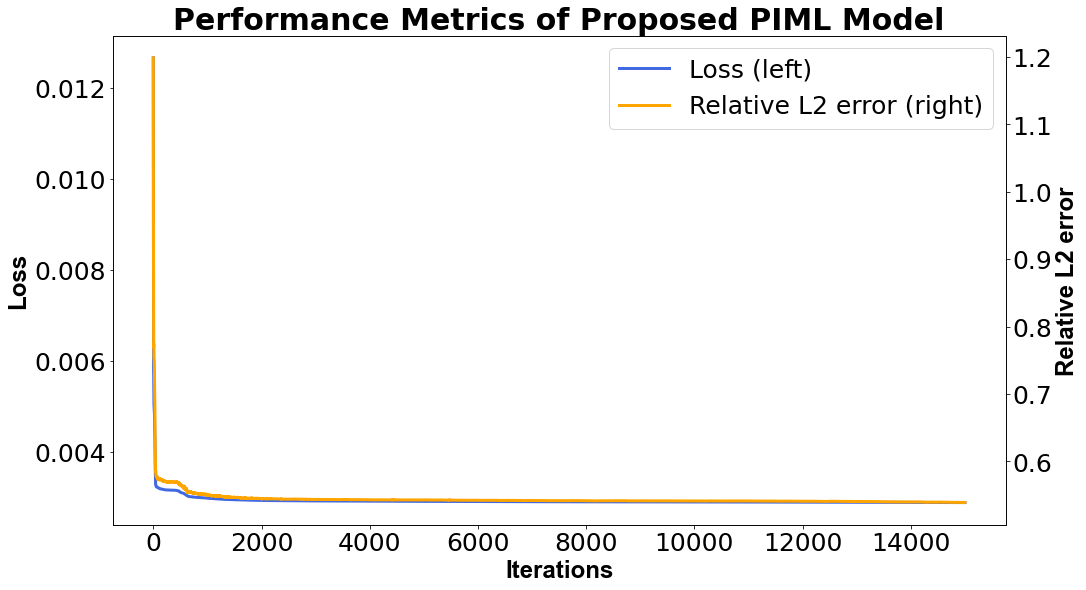

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.020724639632955556
MSE =  0.0027403117211416083
RMSE =  0.05234798679167718
L2 relative error = 0.5026450575154865
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

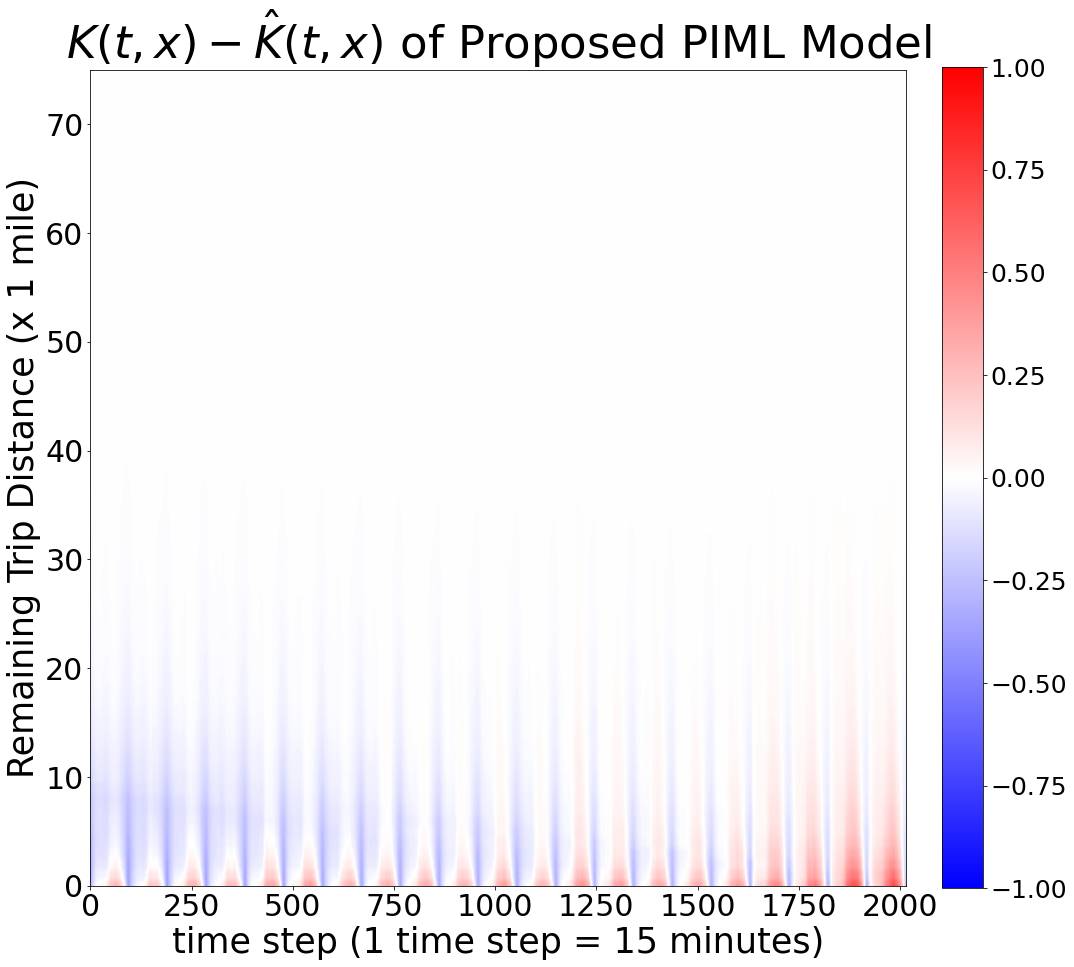

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

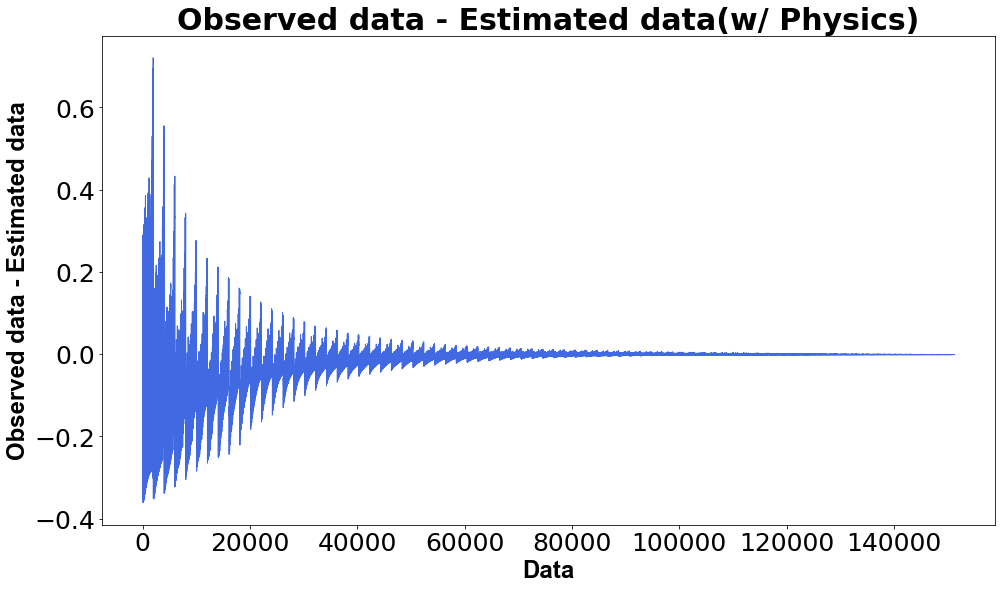

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

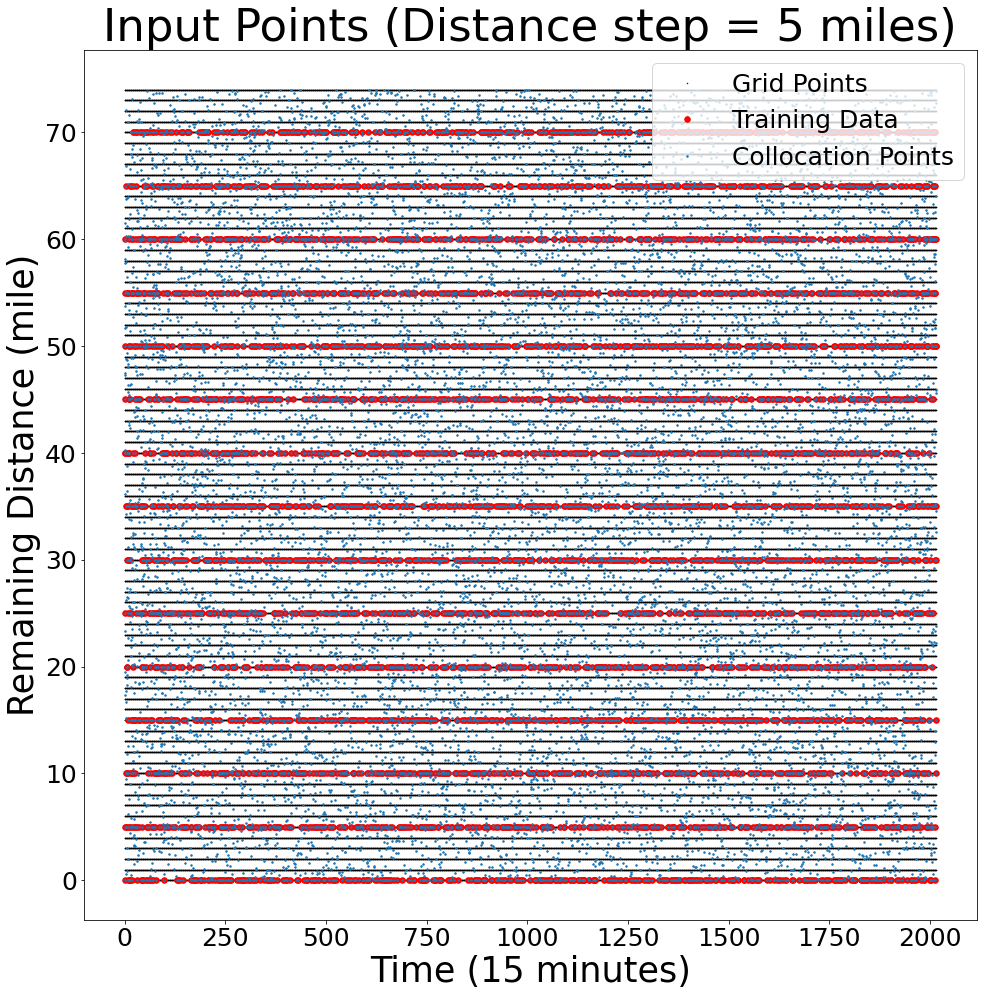

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

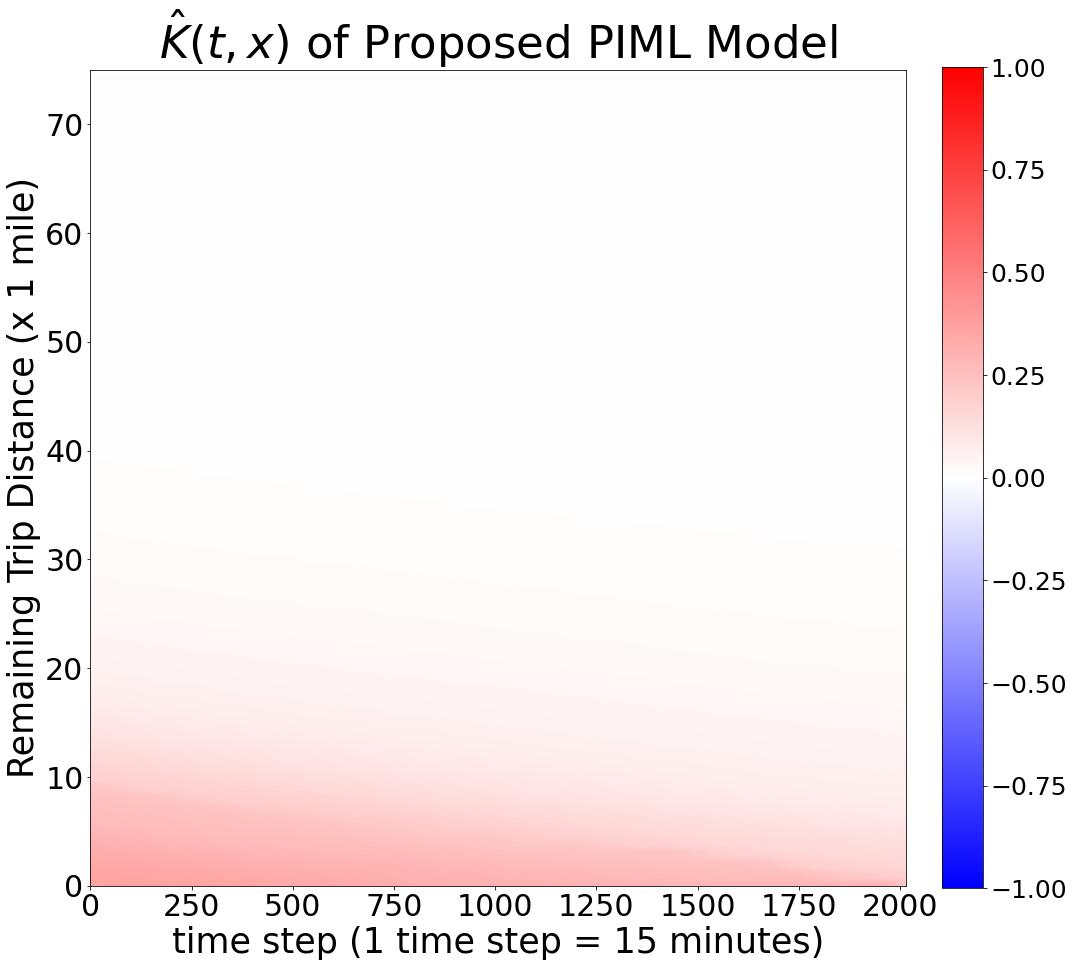

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)